**https://github.com/darkonhub/darkon**

**https://nbviewer.org/github/darkonhub/darkon-examples/blob/master/gradcam/GradcamDemoSequence.ipynb**

**https://github.com/darkonhub/darkon-examples**

**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Libraries**

In [ ]:
import os
import sys
import re
import tqdm
import numpy as np
from numpy import mean,std
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
import itertools
from itertools import chain, product
from itertools import zip_longest
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#import gensim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Load Datasets**

In [ ]:
Train_data = pd.read_csv('/content/drive/MyDrive/Data/COVID-19/Constraint_Train.csv')

In [ ]:
Train_data['label'] = Train_data['label'].apply(lambda x: 1 if x == 'fake' else 0)

In [ ]:
Train_data.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,0
1,2,States reported 1121 deaths a small rise from ...,0
2,3,Politically Correct Woman (Almost) Uses Pandem...,1
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,0
4,5,Populous states can generate large case counts...,0


In [ ]:
Train_data.shape

(6420, 3)

**Text Preprocessing**

In [ ]:
# NLP pre-processing
# remove urls, handles, and the hashtag from hashtags 
# (taken from https://stackoverflow.com/questions/8376691/how-to-remove-hashtag-user-link-of-a-tweet-using-regular-expression)
def remove_urls(text):
  new_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
  return new_text

# make all text lowercase
def text_lowercase(text): 
  return text.lower()

# remove numbers
def remove_numbers(text): 
  result = re.sub(r'\d+', '', text) 
  return result

# remove punctuation
def remove_punctuation(text): 
  translator = str.maketrans('', '', string.punctuation)
  return text.translate(translator)

# function for all pre-processing steps
def preprocessing(text):
  text = text_lowercase(text)
  text = remove_urls(text)
  text = remove_numbers(text)
  text = remove_punctuation(text)
  return text

# pre-processing the text body column
pp_text = []
for text_data in Train_data['tweet']:
  # check if string
  if isinstance(text_data, str):
    pp_text_data = preprocessing(text_data)
    pp_text.append(pp_text_data)
   # if not string
  else:
    pp_text.append(np.NaN)

# add pre-processed column to dataset
Train_data['text'] = pp_text

In [ ]:
df = Train_data
df.head()

,id,tweet,label,text
0,1,The CDC currently reports 99031 deaths. In gen...,0,the cdc currently reports deaths in general t...
1,2,States reported 1121 deaths a small rise from ...,0,states reported deaths a small rise from last...
2,3,Politically Correct Woman (Almost) Uses Pandem...,1,politically correct woman almost uses pandemic...
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,0,indiafightscorona we have covid testing labor...
4,5,Populous states can generate large case counts...,0,populous states can generate large case counts...


In [ ]:
df1 = df[df['label'] == 0]
df1.head()

,id,tweet,label,text
0,1,The CDC currently reports 99031 deaths. In gen...,0,the cdc currently reports deaths in general t...
1,2,States reported 1121 deaths a small rise from ...,0,states reported deaths a small rise from last...
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,0,indiafightscorona we have covid testing labor...
4,5,Populous states can generate large case counts...,0,populous states can generate large case counts...
5,6,"Covid Act Now found ""on average each person in...",0,covid act now found on average each person in ...


In [ ]:
df2 = df[df['label'] == 1]
df2.head()

,id,tweet,label,text
2,3,Politically Correct Woman (Almost) Uses Pandem...,1,politically correct woman almost uses pandemic...
7,8,Obama Calls Trump’s Coronavirus Response A Cha...,1,obama calls trump s coronavirus response a cha...
8,9,"???Clearly, the Obama administration did not l...",1,clearly the obama administration did not leave...
9,10,Retraction—Hydroxychloroquine or chloroquine w...,1,retraction hydroxychloroquine or chloroquine w...
11,12,The NBA is poised to restart this month. In Ma...,1,the nba is poised to restart this month in mar...


In [ ]:
len(df), len(df1), len(df2)

(6420, 3360, 3060)

**Convert one Panda column to list**

In [ ]:
positive_list = list(df1['text'])
positive_list[:5]

['the cdc currently reports  deaths in general the discrepancies in death counts between different sources are small and explicable the death toll stands at roughly  people today',
 'states reported  deaths a small rise from last tuesday southern states reported  of those deaths',
 'indiafightscorona we have  covid testing laboratories in india and as on th august   tests have been done dg staysafe indiawillwin',
 'populous states can generate large case counts but if you look at the new cases per million today  smaller states are showing more cases per million than california or texas al ar id ks ky la ms nv and sc',
 'covid act now found on average each person in illinois with covid  is infecting   other people data shows that the infection growth rate has declined over time this factors in the stay at home order and other restrictions put in place']

In [ ]:
negative_list = list(df2['text'])
negative_list[:5]

['politically correct woman almost uses pandemic as excuse not to reuse plastic bag coronavirus nashville',
 'obama calls trump s coronavirus response a chaotic disaster',
 'clearly the obama administration did not leave any kind of game plan for something like this',
 'retraction hydroxychloroquine or chloroquine with or without a macrolide for treatment of covid  a multinational registry analysis the lancet',
 'the nba is poised to restart this month in march we reported on how the utah jazz got  coronavirus tests in a matter of hours at a time when u s testing was sluggish']

In [ ]:
len(positive_list), len(negative_list)

(3360, 3060)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def nGram(train_text, test_text):
  #unique word and word count
  vectorizer = TfidfVectorizer(ngram_range=(1,7))
  
  X1 = vectorizer.fit_transform(train_text)
  word_list = vectorizer.get_feature_names()
  word_matrix1 = X1.toarray()
  count_list1 = word_matrix1.sum(axis=0)
  A = pd.DataFrame(word_matrix1, columns = word_list)


  X2 = vectorizer.transform(test_text)
  word_list = vectorizer.get_feature_names()
  word_matrix2 = X2.toarray()
  count_list2 = word_matrix2.sum(axis=0)
  B = pd.DataFrame(word_matrix2, columns = word_list)
  return A, B

In [ ]:
X_train, X_test = nGram(df['text'][0:100], df['text'][101:150])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

y_train = label_encoder.fit_transform(df['label'][0:100])
y_test = label_encoder.transform(df['label'][101:150])
label_encoder.classes_

array([0, 1])

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((100, 13225), (49, 13225), (100,), (49,))

#**Darkon**

In [ ]:
#!pip install --upgrade pip

In [ ]:
#!pip uninstall -y tensorflow
#!pip install tensorflow==1.13.2

In [ ]:
#!pip install numpy
#!pip install six
#!pip install opencv-python
#!pip install scikit-image

In [ ]:
!git clone https://github.com/darkonhub/darkon.git

fatal: destination path 'darkon' already exists and is not an empty directory.


**Import packages**

In [ ]:
import darkon
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib import learn
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

**Model Download**

In [ ]:
test_model_dir="/content/darkon/test/data"

In [ ]:
!wget http://download.tensorflow.org/models/resnet_v1_50_2016_08_28.tar.gz
!wget http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz
!wget https://raw.githubusercontent.com/darkonhub/darkon-examples/master/gradcam/sequence.tar

--2022-07-24 14:14:15--  http://download.tensorflow.org/models/resnet_v1_50_2016_08_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.24.128, 2404:6800:4003:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.24.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95073259 (91M) [application/x-tar]
Saving to: ‘resnet_v1_50_2016_08_28.tar.gz.1’

resnet_v1_50_2016_0 100%[===================>]  90.67M  79.3MB/s    in 1.1s    

2022-07-24 14:14:17 (79.3 MB/s) - ‘resnet_v1_50_2016_08_28.tar.gz.1’ saved [95073259/95073259]

--2022-07-24 14:14:17--  http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.68.128, 2404:6800:4003:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.68.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 513324920 (490M) [application/x-tar]
Saving to: ‘vgg_16

In [ ]:
!mkdir -p $test_model_dir
!tar -xf resnet_v1_50_2016_08_28.tar.gz -C $test_model_dir
!tar -xf vgg_16_2016_08_28.tar.gz -C $test_model_dir
!tar -xf sequence.tar -C $test_model_dir

**example sentences and preprocess the sentences**

In [ ]:
tf.reset_default_graph()

#x_raw_pos =["sensitive ensemble performances and good period reconstruction add up to a moving tragedy with some buoyant human moments ."]
#x_raw_neg = ["fails to convince the audience that these brats will ever be anything more than losers . "]

x_raw_pos = positive_list[:10]
x_raw_neg = negative_list[:10]

vocab_path = '/content/darkon/test/data/sequence/vocab'
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)

x_test_batch_pos = np.array(list(vocab_processor.transform(x_raw_pos)))
x_test_batch_neg = np.array(list(vocab_processor.transform(x_raw_neg)))

#x_test_batchroce_pos = np.array(X_test.iloc[[1]])
#x_test_batch_neg = np.array(X_test.iloc[[2]])

y_test_batch = [[1.0, 0.0]]

Instructions for updating:
Please use tensorflow/transform or tf.data.


In [ ]:
x_raw_pos

['the cdc currently reports  deaths in general the discrepancies in death counts between different sources are small and explicable the death toll stands at roughly  people today',
 'states reported  deaths a small rise from last tuesday southern states reported  of those deaths',
 'indiafightscorona we have  covid testing laboratories in india and as on th august   tests have been done dg staysafe indiawillwin']

In [ ]:
x_raw_neg

['politically correct woman almost uses pandemic as excuse not to reuse plastic bag coronavirus nashville',
 'obama calls trump s coronavirus response a chaotic disaster',
 'clearly the obama administration did not leave any kind of game plan for something like this']

**get pretrained text cnn network**

In [ ]:
sess = tf.InteractiveSession()

# Load the saved meta graph and restore variables
checkpoint_file = '/content/darkon/test/data/sequence/model-30000'

#saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))

saver.restore(sess, checkpoint_file)
graph = tf.get_default_graph()   
input_x = graph.get_operation_by_name("input_x").outputs[0]
input_y = graph.get_operation_by_name("input_y").outputs[0]
dropout_keep_prob = graph.get_operation_by_name("dropout_keep_prob").outputs[0]

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /content/darkon/test/data/sequence/model-30000


#**Working on Codes**

##**Darkon**

**gradcam**

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
from tensorflow.python.ops import math_grad
from tensorflow.core.framework import attr_value_pb2
from tensorflow.python.util import compat
from tensorflow.contrib.graph_editor import subgraph


_grad_override_map = {
    'Tanh': 'GuidedTanh',
    'Sigmoid': 'GuidedSigmoid',
    'Relu': 'GuidedRelu',
    'Relu6': 'GuidedRelu6',
    'Elu': 'GuidedElu',
    'Selu': 'GuidedSelu',
    'Softplus': 'GuidedSoftplus',
    'Softsign': 'GuidedSoftsign',
}


def replace_grad_to_guided_grad(g):
    sgv = subgraph.make_view(g)
    with g.gradient_override_map(_grad_override_map):
        for op in sgv.ops:
            _replace_grad(g, op)


def _replace_grad(g, op):
    # ref: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/framework/ops.py
    # tf.Graph._gradient_override_map
    try:
        op_def = op._op_def
        node_def = op._node_def

        if op_def is not None:
            mapped_op_type = g._gradient_override_map[op_def.name]
            node_def.attr["_gradient_op_type"].CopyFrom(
                attr_value_pb2.AttrValue(s=compat.as_bytes(mapped_op_type)))
    except KeyError:
        pass


def guided_grad(grad):
    return tf.where(0. < grad, grad, tf.zeros_like(grad))


@ops.RegisterGradient("GuidedTanh")
def _guided_grad_tanh(op, grad):
    return guided_grad(math_grad._TanhGrad(op, grad))


@ops.RegisterGradient("GuidedSigmoid")
def _guided_grad_sigmoid(op, grad):
    return guided_grad(math_grad._SigmoidGrad(op, grad))


@ops.RegisterGradient("GuidedRelu")
def _guided_grad_relu(op, grad):
    return guided_grad(gen_nn_ops._relu_grad(grad, op.outputs[0]))


@ops.RegisterGradient("GuidedRelu6")
def _guided_grad_relu6(op, grad):
    return guided_grad(gen_nn_ops._relu6_grad(grad, op.outputs[0]))


@ops.RegisterGradient("GuidedElu")
def _guided_grad_elu(op, grad):
    return guided_grad(gen_nn_ops._elu_grad(grad, op.outputs[0]))


@ops.RegisterGradient("GuidedSelu")
def _guided_grad_selu(op, grad):
    return guided_grad(gen_nn_ops._selu_grad(grad, op.outputs[0]))


@ops.RegisterGradient("GuidedSoftplus")
def _guided_grad_softplus(op, grad):
    return guided_grad(gen_nn_ops._softplus_grad(grad, op.outputs[0]))


@ops.RegisterGradient("GuidedSoftsign")
def _guided_grad_softsign(op, grad):
    return guided_grad(gen_nn_ops._softsign_grad(grad, op.outputs[0]))

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
import tensorflow as tf
import numpy as np

_unusable_op_names = (
    'Shape',
    'Reshape',
    'Slice',
    'Pack',
    'Cast',
    'ConcatV2',
    'Const',
    'Identity',
    'ZerosLike',
    'Assign',
    'VariableV2')


def _unusable_ops(op):
    if len(op.outputs) == 0 \
            or 'save' in op.name \
            or 'gradients/' in op.name \
            or '/Initializer' in op.name \
            or op.op_def is None \
            or op.op_def.name in _unusable_op_names:
        return True
    else:
        return False


def candidate_featuremap_op_names(sess, graph, feed_options):
    operations = []
    out_ranks = []
    out_shapes = []

    for op in graph.get_operations():
        if _unusable_ops(op):
            continue

        out_ranks.append(tf.rank(op.outputs[0]))
        out_shapes.append(tf.shape(op.outputs[0]))
        operations.append(op)

    out_ranks_val, out_shapes_val = sess.run([out_ranks, out_shapes], feed_dict=feed_options)

    ret = []
    for out_rank, out_shape, op in zip(out_ranks_val, out_shapes_val, operations):
        if out_rank != 4 or (out_shape[1] == 1 and out_shape[2] == 1) or out_shape[0] != 1:
            continue

        ret.append(op.name)
    return ret


def candidate_predict_op_names(sess, num_classes, graph, feed_options):
    operations = []
    out_ranks = []
    out_shapes = []

    for op in graph.get_operations():
        if _unusable_ops(op):
            continue

        out_ranks.append(tf.rank(op.outputs[0]))
        out_shapes.append(tf.shape(op.outputs[0]))
        operations.append(op)

    out_ranks_val, out_shapes_val = sess.run([out_ranks, out_shapes], feed_dict=feed_options)

    ret = []
    for out_rank, out_shape, op in zip(out_ranks_val, out_shapes_val, operations):
        if out_rank == 1:
            continue
        if np.prod(out_shape) != num_classes:
            continue

        ret.append(op.name)
    return ret

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
"""
References
----------
.. [1] Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra \
"Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization" ICCV2017

"""
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals

import numpy as np
import tensorflow as tf
import cv2
from skimage.transform import resize as skimage_resize

#from .guided_grad import replace_grad_to_guided_grad
#from .candidate_ops import candidate_featuremap_op_names, candidate_predict_op_names
#from .candidate_ops import _unusable_ops


def _deprocess_image(x):
    # Same normalization as in:
    # https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x


class Gradcam:
    """ Gradcam Class

    Parameters
    ----------
    x_placeholder : tf.Tensor
        Data place holder
        Tensor from tf.placeholder()
    num_classes: int
        number of classes
    featuremap_op_name : str
        Operation name of CNN feature map layer
        To get the list of candidate names, use ``Gradcam.candidate_featuremap_op_names()``
    predict_op_name : str
        Operation name of prediction layer (decision output)
        To get the list of candidate names, use ``Gradcam.candidate_predict_op_names()``
    graph : tf.Graph
        Tensorflow graph

    """
    def __init__(self, x_placeholder, num_classes, featuremap_op_name, predict_op_name=None, graph=None):
        self._x_placeholder = x_placeholder
        graph = graph if graph is not None else tf.get_default_graph()
        self.graph = graph

        predict_op_name = self._find_prob_layer(predict_op_name, graph)
        self._prob_ts = graph.get_operation_by_name(predict_op_name).outputs[0]
        self._target_ts = graph.get_operation_by_name(featuremap_op_name).outputs[0]

        self._class_idx = tf.placeholder(tf.int32)
        top1 = tf.argmax(tf.reshape(self._prob_ts, [-1]))

        loss_by_idx = tf.reduce_sum(tf.multiply(self._prob_ts, tf.one_hot(self._class_idx, num_classes)), axis=1)
        loss_by_top1 = tf.reduce_sum(tf.multiply(self._prob_ts, tf.one_hot(top1, num_classes)), axis=1)
        self._grad_by_idx = self._normalize(tf.gradients(loss_by_idx, self._target_ts)[0])
        self._grad_by_top1 = self._normalize(tf.gradients(loss_by_top1, self._target_ts)[0])

        replace_grad_to_guided_grad(graph)

        max_output = tf.reduce_max(self._target_ts, axis=2)
        self._saliency_map = tf.gradients(tf.reduce_sum(max_output), x_placeholder)[0]

    def gradcam(self, sess, input_data, target_index=None, feed_options=dict()):
        """ Calculate Grad-CAM (class activation map) and Guided Grad-CAM for given input on target class

        Parameters
        ----------
        sess: tf.Session
            Tensorflow session
        input_data : numpy.ndarray
            A single input instance
        target_index : int
            Target class index
            If None, predicted class index is used
        feed_options : dict
            Optional parameters to graph

        Returns
        -------
        dict

        Note
        ----
        Keys in return:
            * gradcam_img: Heatmap overlayed on input
            * guided_gradcam_img: Guided Grad-CAM result
            * heatmap: Heatmap of input on the target class
            * guided_backprop: Guided backprop result

        """
        input_feed = np.expand_dims(input_data, axis=0)
        if input_data.ndim == 3:
            is_image = True
            image_height, image_width = input_data.shape[:2]
        if input_data.ndim == 1:
            is_image = False
            input_length = input_data.shape[0]

        if target_index is not None:
            feed_dict = {self._x_placeholder: input_feed, self._class_idx: target_index}
            feed_dict.update(feed_options)
            conv_out_eval, grad_eval = sess.run([self._target_ts, self._grad_by_idx], feed_dict=feed_dict)
        else:
            feed_dict = {self._x_placeholder: input_feed}
            feed_dict.update(feed_options)
            conv_out_eval, grad_eval = sess.run([self._target_ts, self._grad_by_top1], feed_dict=feed_dict)

        weights = np.mean(grad_eval, axis=(0, 1, 2))
        conv_out_eval = np.squeeze(conv_out_eval, axis=0)
        cam = np.zeros(conv_out_eval.shape[:2], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * conv_out_eval[:, :, i]

        if is_image:
            cam += 1
            cam = cv2.resize(cam, (image_height, image_width))
            saliency_val = sess.run(self._saliency_map, feed_dict={self._x_placeholder: input_feed})
            saliency_val = np.squeeze(saliency_val, axis=0)
        else:
            cam = skimage_resize(cam, (input_length, 1), preserve_range=True, mode='reflect')
            cam = np.transpose(cam)

        cam = np.maximum(cam, 0)
        heatmap = cam / np.max(cam)

        ret = {'heatmap': heatmap}

        if is_image:
            ret.update({
                'gradcam_img': self.overlay_gradcam(input_data, heatmap),
                'guided_gradcam_img': _deprocess_image(saliency_val * heatmap[..., None]),
                'guided_backprop': saliency_val
            })
        return ret

    @staticmethod
    def candidate_featuremap_op_names(sess, graph=None, feed_options=None):
        """ Returns the list of candidates for operation names of CNN feature map layer

        Parameters
        ----------
        sess: tf.Session
            Tensorflow session
        graph: tf.Graph
            Tensorflow graph
        feed_options: dict
            Optional parameters to graph
        Returns
        -------
        list
            String list of candidates

        """
        graph = graph if graph is not None else tf.get_default_graph()
        feed_options = feed_options if feed_options is not None else {}
        return candidate_featuremap_op_names(sess, graph, feed_options)

    @staticmethod
    def candidate_predict_op_names(sess, num_classes, graph=None, feed_options=None):
        """ Returns the list of candidate for operation names of prediction layer

        Parameters
        ----------
        sess: tf.Session
            Tensorflow session
        num_classes: int
            Number of prediction classes
        graph: tf.Graph
            Tensorflow graph
        feed_options: dict
            Optional parameters to graph
        Returns
        -------
        list
            String list of candidates

        """
        graph = graph if graph is not None else tf.get_default_graph()
        feed_options = feed_options if feed_options is not None else {}
        return candidate_predict_op_names(sess, num_classes, graph, feed_options)

    @staticmethod
    def overlay_gradcam(image, heatmap):
        """ Overlay heatmap on input data
        """
        output_image = np.array(image)
        output_image -= np.min(output_image)
        output_image = np.minimum(output_image, 255)

        cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
        output_image = np.float32(cam) + np.float32(output_image)
        output_image = 255 * output_image / np.max(output_image)
        output_image = np.uint8(output_image)
        return output_image

    @staticmethod
    def _find_prob_layer(output_name, graph):
        if output_name is not None:
            return output_name

        for op in graph.get_operations():
            if _unusable_ops(op):
                continue

            output_name = op.name
        return output_name

    @staticmethod
    def _normalize(x):
        return tf.div(x, (tf.sqrt(tf.reduce_mean(tf.square(x), axis=1)) + 1e-5))

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
#from . import gradcam
# from . import guided_grad
# from . import extract_ops

__all__ = ["gradcam"]

**influence**

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
""" Feeding interface for Influence class

"""
from __future__ import absolute_import
from __future__ import unicode_literals

import abc
import six


@six.add_metaclass(abc.ABCMeta)
class InfluenceFeeder:
    @abc.abstractmethod
    def reset(self):
        """ reset dataset
        """
        raise RuntimeError('must be implemented')

    @abc.abstractmethod
    def train_batch(self, batch_size):
        """ training data feeder by batch sampling

        Parameters
        ----------
        batch_size : batch size

        Returns
        -------
        xs : feed input values
        ys : feed label values

        """
        raise RuntimeError('must be implemented')

    @abc.abstractmethod
    def train_one(self, index):
        """ single training data feeder

        Parameters
        ----------
        index : training sample index

        Returns
        -------
        x : feed one input value
        y : feed one label value

        """
        raise RuntimeError('must be implemented')

    @abc.abstractmethod
    def test_indices(self, indices):
        """ test data feeder

        Parameters
        ----------
        indices : testing sample index

        Returns
        -------
        x : feed input values
        y : feed label values

        """
        raise RuntimeError('must be implemented')

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
"""
References
----------
.. [1] Pang Wei Koh and Percy Liang "Understanding Black-box Predictions via Influence Functions" ICML2017

"""
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals

#from .feeder import InfluenceFeeder  # noqa: ignore=F401
#from ..log import logger

import numpy as np
import tensorflow as tf
from tensorflow.python.ops.gradients_impl import _hessian_vector_product

import os
import time
import hashlib
import json
from functools import wraps

_using_fully_tf = True


def _timing(f):
    @wraps(f)
    def wrap(*args, **kwargs):
        time1 = time.time()
        ret = f(*args, **kwargs)
        time2 = time.time()
        logger.debug('* %s function took [%.3fs]' % (f.__name__, time2-time1))
        return ret
    return wrap


class Influence:
    """ Influence Class

    Parameters
    ----------
    workspace: str
        Path for workspace directory
    feeder : InfluenceFeeder
        Dataset feeder
    loss_op_train : tf.Operation
        Tensor for loss function used for training. it may includes regularization.
    loss_op_test : tf.Operation
        Tensor for loss function for inference.
    x_placeholder : tf.Tensor
        Data place holder
        Tensor from tf.placeholder()
    y_placeholder : tf.Tensor
        Target place holder
        Tensor from tf.placeholder()
    test_feed_options : dict
        Optional parameters to run loss operation in testset
    train_feed_options : dict
        Optional parameters to run loss operation in trainset
    trainable_variables : tuple, or list
        Trainable variables to be used
        If None, all variables are trainable
        Default: None


    """
    def __init__(self, workspace, feeder, loss_op_train, loss_op_test, x_placeholder, y_placeholder,
                 test_feed_options=None, train_feed_options=None, trainable_variables=None):
        self.workspace = workspace
        self.feeder = feeder
        self.x_placeholder = x_placeholder
        self.y_placeholder = y_placeholder
        self.test_feed_options = test_feed_options if test_feed_options else dict()
        self.train_feed_options = train_feed_options if train_feed_options else dict()

        if trainable_variables is None:
            trainable_variables = (
                tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES) +
                tf.get_collection(tf.GraphKeys.TRAINABLE_RESOURCE_VARIABLES))

        self.loss_op_train = loss_op_train
        self.grad_op_train = tf.gradients(loss_op_train, trainable_variables)
        self.grad_op_test = tf.gradients(loss_op_test, trainable_variables)

        self.v_cur_estimated = [tf.placeholder(tf.float32, shape=a.get_shape()) for a in trainable_variables]
        self.v_test_grad = [tf.placeholder(tf.float32, shape=a.get_shape()) for a in trainable_variables]
        self.v_ihvp = tf.placeholder(tf.float64, shape=[None])
        self.v_param_damping = tf.placeholder(tf.float32)
        self.v_param_scale = tf.placeholder(tf.float32)
        self.v_param_total_trainset = tf.placeholder(tf.float64)

        self.inverse_hvp = None
        self.trainable_variables = trainable_variables

        with tf.name_scope('darkon_ihvp'):
            self.hessian_vector_op = _hessian_vector_product(loss_op_train, trainable_variables, self.v_cur_estimated)
            self.estimation_op = [
                a + (b * self.v_param_damping) - (c / self.v_param_scale)
                for a, b, c in zip(self.v_test_grad, self.v_cur_estimated, self.hessian_vector_op)
            ]

        with tf.name_scope('darkon_grad_diff'):
            flatten_inverse_hvp = tf.reshape(self.v_ihvp, shape=(-1, 1))
            flatten_grads = tf.concat([tf.reshape(a, (-1,)) for a in self.grad_op_train], 0)
            flatten_grads = tf.reshape(flatten_grads, shape=(1, -1,))
            flatten_grads = tf.cast(flatten_grads, tf.float64)
            flatten_grads /= self.v_param_total_trainset
            self.grad_diff_op = tf.matmul(flatten_grads, flatten_inverse_hvp)

        self.ihvp_config = {
            'scale': 1e4,
            'damping': 0.01,
            'num_repeats': 1,
            'recursion_batch_size': 10,
            'recursion_depth': 10000
        }

        if not os.path.exists(self.workspace):
            os.makedirs(self.workspace)

    @_timing
    def upweighting_influence(self, sess, test_indices, test_batch_size, approx_params,
                              train_indices, num_total_train_example, force_refresh=False):
        """ Calculate influence score of given training samples that affect on the test samples
         Negative value indicates bad effect on the test loss

        Parameters
        ----------
        sess: tf.Session
            Tensorflow session
        test_indices: list
            Test samples to be used. Influence on these samples are calculated.
        test_batch_size: int
            batch size for test samples
        approx_params: dict
            Parameters for inverse hessian vector product approximation
            Default:
                {'scale': 1e4,
                'damping': 0.01,
                'num_repeats': 1,
                'recursion_batch_size': 10,
                'recursion_depth': 10000}
        train_indices: list
            Training samples indices to be calculated.
        num_total_train_example: int
            Number of total training samples used for training,
            which might be different from the size of train_indices
        force_refresh: bool
            If False, it calculates only when test samples and parameters are changed.
            Default: False

        Returns
        -------
        numpy.ndarray

        """
        self._prepare(sess, test_indices, test_batch_size, approx_params, force_refresh)

        self.feeder.reset()
        score = self._grad_diffs(sess, train_indices, num_total_train_example)
        logger.info('Multiplying by %s train examples' % score.size)
        return score

    @_timing
    def upweighting_influence_batch(self, sess, test_indices, test_batch_size, approx_params,
                                    train_batch_size, train_iterations, subsamples=-1, force_refresh=False):
        """ Iteratively calculate influence scores for training data sampled by batch sampler
        Negative value indicates bad effect on the test loss

        Parameters
        ----------
        sess: tf.Session
            Tensorflow session
        test_indices: list
            Test samples to be used. Influence on these samples are calculated.
        test_batch_size: int
            batch size for test samples
        approx_params: dict
            Parameters for inverse hessian vector product approximation
            Default:
                {'scale': 1e4,
                'damping': 0.01,
                'num_repeats': 1,
                'recursion_batch_size': 10,
                'recursion_depth': 10000}
        train_batch_size: int
            Batch size of training samples
        train_iterations: int
            Number of iterations
        subsamples: int
            Number of training samples in a batch to be calculated.
            If -1, all samples are calculated (no subsampling).
            Default: -1
        force_refresh: bool
            If False, it calculates only when test samples and parameters are changed.
            Default: False

        Returns
        -------
        numpy.ndarray

        """
        self._prepare(sess, test_indices, test_batch_size, approx_params, force_refresh)

        self.feeder.reset()
        score = self._grad_diffs_all(sess, train_batch_size, train_iterations, subsamples)
        logger.info('Multiplying by %s train examples' % score.size)
        return score

    @_timing
    def _prepare(self, sess, test_indices, test_batch_size, approx_params, force_refresh):
        """ Calculate inverse hessian vector product, and save it in workspace

        Parameters
        ----------
        sess: tf.Session
            Tensorflow session
        test_indices: list
            Test samples to be used. Influence on these samples are calculated.
        test_batch_size: int
            batch size for test samples
        force_refresh: bool
            If False, it calculates only when test samples and parameters are changed.
            Default: False
        approx_params: dict
            Parameters for inverse hessian vector product approximation

        """
        # update ihvp approx params
        if approx_params is not None:
            for param_key in approx_params.keys():
                if param_key not in self.ihvp_config:
                    raise RuntimeError('unknown ihvp config param is approx_params')
            self.ihvp_config.update(approx_params)

        inv_hvp_path = self._path(self._approx_filename(sess, test_indices))
        if not os.path.exists(inv_hvp_path) or force_refresh:
            self.feeder.reset()
            test_grad_loss = self._get_test_grad_loss(sess, test_indices, test_batch_size)
            logger.info('Norm of test gradient: %s' % np.linalg.norm(np.concatenate([a.reshape(-1) for a in test_grad_loss])))
            self.inverse_hvp = self._get_inverse_hvp_lissa(sess, test_grad_loss)
            np.savez(inv_hvp_path, inverse_hvp=self.inverse_hvp, encoding='bytes')
            logger.info('Saved inverse HVP to %s' % inv_hvp_path)
        else:
            self.inverse_hvp = np.load(inv_hvp_path, encoding='bytes')['inverse_hvp']
            logger.info('Loaded inverse HVP from %s' % inv_hvp_path)

    def _get_test_grad_loss(self, sess, test_indices, test_batch_size):
        if test_indices is not None:
            num_iter = int(np.ceil(len(test_indices) / test_batch_size))
            test_grad_loss = None
            for i in range(num_iter):
                start = i * test_batch_size
                end = int(min((i + 1) * test_batch_size, len(test_indices)))
                size = float(end - start)

                test_feed_dict = self._make_test_feed_dict(*self.feeder.test_indices(test_indices[start:end]))
                temp = sess.run(self.grad_op_test, feed_dict=test_feed_dict)
                temp = np.asarray(temp)

                temp *= size
                if test_grad_loss is None:
                    test_grad_loss = temp
                else:
                    test_grad_loss += temp

            test_grad_loss /= len(test_indices)
        else:
            raise RuntimeError('unsupported yet')
        return test_grad_loss

    def _approx_filename(self, sess, test_indices):
        sha = hashlib.sha1()

        # weights
        vs = sess.run(self.trainable_variables)
        for a in vs:
            sha.update(a.data)

        # test_indices
        np_test_indices = np.array(list(test_indices))
        sha.update(np_test_indices.data)

        # approx_params
        sha.update(json.dumps(self.ihvp_config, sort_keys=True).encode('utf-8'))
        return 'ihvp.' + sha.hexdigest() + '.npz'

    def _get_inverse_hvp_lissa(self, sess, test_grad_loss):
        ihvp_config = self.ihvp_config
        print_iter = ihvp_config['recursion_depth'] / 10

        inverse_hvp = None
        for _ in range(ihvp_config['num_repeats']):
            cur_estimate = test_grad_loss
            # debug_diffs_estimation = []
            # prev_estimation_norm = np.linalg.norm(np.concatenate([a.reshape(-1) for a in cur_estimate]))

            for j in range(ihvp_config['recursion_depth']):
                train_batch_data, train_batch_label = self.feeder.train_batch(ihvp_config['recursion_batch_size'])
                feed_dict = self._make_train_feed_dict(train_batch_data, train_batch_label)
                feed_dict = self._update_feed_dict(feed_dict, cur_estimate, test_grad_loss)

                if _using_fully_tf:
                    feed_dict.update({
                        self.v_param_damping: 1 - self.ihvp_config['damping'],
                        self.v_param_scale: self.ihvp_config['scale']
                    })
                    cur_estimate = sess.run(self.estimation_op, feed_dict=feed_dict)
                else:
                    hessian_vector_val = sess.run(self.hessian_vector_op, feed_dict=feed_dict)
                    hessian_vector_val = np.array(hessian_vector_val)
                    cur_estimate = test_grad_loss + (1 - ihvp_config['damping']) * cur_estimate - hessian_vector_val / ihvp_config['scale']

                # curr_estimation_norm = np.linalg.norm(np.concatenate([a.reshape(-1) for a in cur_estimate]))
                # debug_diffs_estimation.append(curr_estimation_norm - prev_estimation_norm)
                # prev_estimation_norm = curr_estimation_norm

                if (j % print_iter == 0) or (j == ihvp_config['recursion_depth'] - 1):
                    logger.info("Recursion at depth %s: norm is %.8lf" %
                                (j, np.linalg.norm(np.concatenate([a.reshape(-1) for a in cur_estimate]))))

            if inverse_hvp is None:
                inverse_hvp = np.array(cur_estimate) / ihvp_config['scale']
            else:
                inverse_hvp += np.array(cur_estimate) / ihvp_config['scale']

            # np.savetxt(self._path('debug_diffs_estimation_{}.txt'.format(sample_idx)), debug_diffs_estimation)

        inverse_hvp /= ihvp_config['num_repeats']
        return inverse_hvp

    def _update_feed_dict(self, feed_dict, cur_estimated, test_grad_loss):
        for placeholder, var in zip(self.v_cur_estimated, cur_estimated):
            feed_dict[placeholder] = var

        for placeholder, var in zip(self.v_test_grad, test_grad_loss):
            feed_dict[placeholder] = var
        return feed_dict

    @_timing
    def _grad_diffs(self, sess, train_indices, num_total_train_example):
        inverse_hvp = np.concatenate([a.reshape(-1) for a in self.inverse_hvp])

        num_to_remove = len(train_indices)
        predicted_grad_diffs = np.zeros([num_to_remove])

        for counter, idx_to_remove in enumerate(train_indices):
            single_data, single_label = self.feeder.train_one(idx_to_remove)
            feed_dict = self._make_train_feed_dict([single_data], [single_label])
            predicted_grad_diffs[counter] = self._grad_diff(sess, feed_dict, num_total_train_example, inverse_hvp)

            if (counter % 1000) == 0:
                logger.info('counter: {} / {}'.format(counter, num_to_remove))

        return predicted_grad_diffs

    @_timing
    def _grad_diffs_all(self, sess, train_batch_size, num_iters, num_subsampling):
        num_total_train_example = num_iters * train_batch_size
        if num_subsampling > 0:
            num_diffs = num_iters * num_subsampling
        else:
            num_diffs = num_iters * train_batch_size

        inverse_hvp = np.concatenate([a.reshape(-1) for a in self.inverse_hvp])
        predicted_grad_diffs = np.zeros([num_diffs])

        counter = 0
        for it in range(num_iters):
            train_batch_data, train_batch_label = self.feeder.train_batch(train_batch_size)

            if num_subsampling > 0:
                for idx in range(num_subsampling):
                    feed_dict = self._make_train_feed_dict(train_batch_data[idx:idx + 1], train_batch_label[idx:idx + 1])
                    predicted_grad_diffs[counter] = self._grad_diff(sess, feed_dict, num_total_train_example, inverse_hvp)
                    counter += 1
            else:
                for single_data, single_label in zip(train_batch_data, train_batch_label):
                    feed_dict = self._make_train_feed_dict([single_data], [single_label])
                    predicted_grad_diffs[counter] = self._grad_diff(sess, feed_dict, num_total_train_example, inverse_hvp)
                    counter += 1

            if (it % 100) == 0:
                logger.info('iter: {}/{}'.format(it, num_iters))

        return predicted_grad_diffs

    def _grad_diff(self, sess, feed_dict, num_total_train_example, inverse_hvp):
        if _using_fully_tf:
            feed_dict.update({
                self.v_ihvp: inverse_hvp,
                self.v_param_total_trainset: num_total_train_example
            })
            return sess.run(self.grad_diff_op, feed_dict=feed_dict)
        else:
            train_grads = sess.run(self.grad_op_train, feed_dict=feed_dict)
            train_grads = np.concatenate([a.reshape(-1) for a in train_grads])
            train_grads /= num_total_train_example
            return np.dot(inverse_hvp, train_grads)

    def _make_test_feed_dict(self, xs, ys):
        ret = {
            self.x_placeholder: xs,
            self.y_placeholder: ys,
        }
        ret.update(self.test_feed_options)
        return ret

    def _make_train_feed_dict(self, xs, ys):
        ret = {
            self.x_placeholder: xs,
            self.y_placeholder: ys,
        }
        ret.update(self.train_feed_options)
        return ret

    def _path(self, *paths):
        return os.path.join(self.workspace, *paths)

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
#from . import feeder
#from . import influence

__all__ = ["feeder", "influence"]

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
import logging
from logging.handlers import RotatingFileHandler


class DarkonLogger:
    """ darkon package logger
    """
    def __init__(self):
        _formatter = logging.Formatter('%(asctime)s %(name)s %(levelname)-4s: %(message)s')
        # _file_handler = logging.handler.FileHandler(__package__ + '.log')
        _file_handler = RotatingFileHandler('darkon.log', maxBytes=1024*1024*100)
        
        _file_handler.setFormatter(_formatter)
        _file_handler.setLevel(logging.DEBUG)
        _stream_handler = logging.StreamHandler()
        _stream_handler.setFormatter(_formatter)
        _stream_handler.setLevel(logging.INFO)

        _logger = logging.getLogger(__package__)
        _logger.setLevel(logging.DEBUG)
        _logger.addHandler(_file_handler)
        _logger.addHandler(_stream_handler)
        self._logger = _logger

        _logger.debug('----------------------------')
        _logger.debug('start logging darkon package')

    @property
    def logger(self):
        return self._logger


logger = DarkonLogger().logger

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
#from .influence.influence import Influence  # noqa: ignore=F401
#from .influence.influence import InfluenceFeeder  # noqa: ignore=F401
#from .gradcam.gradcam import Gradcam  # noqa: ignore=F401

__all__ = ["influence", "gradcam"]

##**Docs**

**src**

In [ ]:
# -*- coding: utf-8 -*-
#
# darkon documentation build configuration file, created by
# sphinx-quickstart on Fri Nov 17 09:41:22 2017.
#
# This file is execfile()d with the current directory set to its
# containing dir.
#
# Note that not all possible configuration values are present in this
# autogenerated file.
#
# All configuration values have a default; values that are commented out
# serve to show the default.

# If extensions (or modules to document with autodoc) are in another directory,
# add these directories to sys.path here. If the directory is relative to the
# documentation root, use os.path.abspath to make it absolute, like shown here.
#
import os
import sys
pkg_root = os.path.abspath('../../')
sys.path.insert(0, pkg_root)
import json

# -- General configuration ------------------------------------------------

# If your documentation needs a minimal Sphinx version, state it here.
#
# needs_sphinx = '1.0'

# Add any Sphinx extension module names here, as strings. They can be
# extensions coming with Sphinx (named 'sphinx.ext.*') or your custom
# ones.
extensions = ['sphinx.ext.autodoc',
    'sphinx.ext.intersphinx',
    'sphinx.ext.imgmath',
    'sphinx.ext.viewcode',
    'sphinx.ext.githubpages']

extensions += [
        'sphinx.ext.napoleon',
        'm2r'
        ]

# Napoleon settings
napoleon_google_docstring = True
napoleon_numpy_docstring = True
napoleon_include_init_with_doc = False
napoleon_include_private_with_doc = False
napoleon_include_special_with_doc = True
napoleon_use_admonition_for_examples = False
napoleon_use_admonition_for_notes = False
napoleon_use_admonition_for_references = False
napoleon_use_ivar = False
napoleon_use_param = True
napoleon_use_rtype = False

# Add any paths that contain templates here, relative to this directory.
templates_path = ['_templates']

# The suffix(es) of source filenames.
# You can specify multiple suffix as a list of string:
#
source_suffix = ['.rst', '.md']
#source_suffix = '.rst'

# The master toctree document.
master_doc = 'index'

#info = json.load(open(os.path.join(pkg_root, 'info.json')))
info = json.load(open(os.path.join(pkg_root, '/content/darkon/info.json')))

# General information about the project.
project = info['name']
copyright = info['copyright']
author = info['authors']

# The version info for the project you're documenting, acts as replacement for
# |version| and |release|, also used in various other places throughout the
# built documents.
#
# The short X.Y version.
version = info['version']
# The full version, including alpha/beta/rc tags.
release = info['version']

# The language for content autogenerated by Sphinx. Refer to documentation
# for a list of supported languages.
#
# This is also used if you do content translation via gettext catalogs.
# Usually you set "language" from the command line for these cases.
language = None

# List of patterns, relative to source directory, that match files and
# directories to ignore when looking for source files.
# This patterns also effect to html_static_path and html_extra_path
exclude_patterns = [
    '_build',
    'Thumbs.db',
    '.DS_Store',
    'README.md'
]

# The name of the Pygments (syntax highlighting) style to use.
pygments_style = 'sphinx'

# If true, `todo` and `todoList` produce output, else they produce nothing.
todo_include_todos = False


# -- Options for HTML output ----------------------------------------------

# The theme to use for HTML and HTML Help pages.  See the documentation for
# a list of builtin themes.
#
html_theme = 'alabaster'

# Theme options are theme-specific and customize the look and feel of a theme
# further.  For a list of options available for each theme, see the
# documentation.
#
html_theme_options = {
    'logo': 'logo.png',
    'github_user': 'darkonhub',
    'github_repo': 'darkon',
    'github_button': True,
    'github_type': 'star',
    'github_banner': True,
    'analytics_id': 'UA-109936098-1',
    'description': 'Toolkit to Hack Your Deep Learning Models.',
    'code_font_family': ('monaco', 'Consolas', 'Menlo', 'Deja Vu Sans Mono', 'Bitstream Vera Sans Mono', 'monospace'),
    'fixed_sidebar': True,
}
# Add any paths that contain custom static files (such as style sheets) here,
# relative to this directory. They are copied after the builtin static files,
# so a file named "default.css" will overwrite the builtin "default.css".
html_static_path = ['_static']

# Custom sidebar templates, must be a dictionary that maps document names
# to template names.
#
# This is required for the alabaster theme
# refs: http://alabaster.readthedocs.io/en/latest/installation.html#sidebars
html_sidebars = {
    '**': [
        'about.html',
        'navigation.html',
        'relations.html',  # needs 'show_related': True theme option to display
        'searchbox.html',
    ]
}

html_favicon = "_static/favicon.ico"


# -- Options for HTMLHelp output ------------------------------------------

# Output file base name for HTML help builder.
htmlhelp_basename = 'darkondoc'


# -- Options for LaTeX output ---------------------------------------------

latex_elements = {
    # The paper size ('letterpaper' or 'a4paper').
    #
    # 'papersize': 'letterpaper',

    # The font size ('10pt', '11pt' or '12pt').
    #
    # 'pointsize': '10pt',

    # Additional stuff for the LaTeX preamble.
    #
    # 'preamble': '',

    # Latex figure (float) alignment
    #
    # 'figure_align': 'htbp',
}

# Grouping the document tree into LaTeX files. List of tuples
# (source start file, target name, title,
#  author, documentclass [howto, manual, or own class]).
latex_documents = [
    (master_doc, 'darkon.tex', u'darkon Documentation',
     u'Neosapience, Inc.', 'manual'),
]


# -- Options for manual page output ---------------------------------------

# One entry per manual page. List of tuples
# (source start file, name, description, authors, manual section).
man_pages = [
    (master_doc, 'darkon', u'darkon Documentation',
     [author], 1)
]


# -- Options for Texinfo output -------------------------------------------

# Grouping the document tree into Texinfo files. List of tuples
# (source start file, target name, title, author,
#  dir menu entry, description, category)
texinfo_documents = [
    (master_doc, 'darkon', u'darkon Documentation',
     author, 'darkon', 'One line description of project.',
     'Miscellaneous'),
]




# Example configuration for intersphinx: refer to the Python standard library.
intersphinx_mapping = {
    'https://docs.python.org/': None,
    'numpy': ('http://docs.scipy.org/doc/numpy/', None),
}


highlight_language = 'python'
add_module_names = False


##**test**

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
import tensorflow as tf


def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)


def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
import unittest

import darkon
import numpy as np

_num_train_data = 20
_dim_features = 5
_num_test_data = 3
_classes = 2


#class MyFeeder(darkon.InfluenceFeeder):
class MyFeeder():
    def __init__(self):
        self.train_x = np.random.uniform(size=_num_train_data * _dim_features).reshape([_num_train_data, -1])
        self.train_y = np.random.randint(_classes, size=_num_train_data).reshape([-1])
        self.test_x = np.random.uniform(size=_num_test_data * _dim_features).reshape([_num_test_data, -1])
        self.test_y = np.random.randint(_classes, size=_num_test_data).reshape([-1])

        self.train_y = np.eye(_classes)[self.train_y]
        self.test_y = np.eye(_classes)[self.test_y]

    def reset(self):
        np.random.seed(97)

    def train_batch(self, batch_size):
        idx = np.random.choice(_num_train_data - batch_size + 1, 1)[0]
        return self.train_x[idx:idx + batch_size], self.train_y[idx:idx + batch_size]

    def train_one(self, index):
        return self.train_x[index], self.train_y[index]

    def test_indices(self, indices):
        return self.test_x[indices], self.test_y[indices]


class TestInfluenceFeeder(unittest.TestCase):
    def test_interface_without_implementation(self):
        self.assertRaises(Exception, darkon.InfluenceFeeder)

    def test_interface(self):
        class ParentTestFeeder(darkon.InfluenceFeeder):
            def reset(self):
                return super(ParentTestFeeder, self).reset()

            def train_batch(self, batch_size):
                return super(ParentTestFeeder, self).train_batch(batch_size)

            def train_one(self, index):
                return super(ParentTestFeeder, self).train_batch(index)

            def test_indices(self, indices):
                return super(ParentTestFeeder, self).train_batch(indices)

        feeder = ParentTestFeeder()
        self.assertRaises(RuntimeError, feeder.reset)
        self.assertRaises(RuntimeError, feeder.train_batch, 1)
        self.assertRaises(RuntimeError, feeder.train_one, 0)
        self.assertRaises(RuntimeError, feeder.test_indices, [0])

    def test_reset(self):
        feeder = MyFeeder()
        feeder.reset()
        data1 = np.array(feeder.train_batch(4)[0])
        data1_next = np.array(feeder.train_batch(4)[0])
        self.assertFalse(np.all(data1 == data1_next))

        feeder.reset()
        data2 = np.array(feeder.train_batch(4)[0])
        data2_next = np.array(feeder.train_batch(4)[0])
        self.assertTrue(np.all(data1 == data2))
        self.assertTrue(np.all(data1_next == data2_next))

    def test_train_batch(self):
        feeder = MyFeeder()
        data, label = feeder.train_batch(4)
        self.assertEqual(4, len(data))
        self.assertEqual(4, len(label))

        data, label = feeder.train_batch(1)
        self.assertEqual(1, len(data))
        self.assertEqual(1, len(label))

    def test_test_indices(self):
        feeder = MyFeeder()
        data, label = feeder.test_indices([2, 0])
        self.assertEqual(2, len(data))
        self.assertEqual(2, len(label))

    def test_train_one(self):
        feeder = MyFeeder()
        data, label = feeder.train_one(2)
        self.assertEqual(_dim_features, data.size)
        self.assertEqual(_classes, label.size)

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
import unittest

import darkon
import tensorflow as tf
import numpy as np
#from .tf_util import weight_variable, bias_variable


_num_train_data = 20
_dim_features = 5
_num_test_data = 3
_classes = 2
_batch_size = 4
_num_iterations = 5


def nn_graph_dropout():
    # create graph
    x = tf.placeholder(tf.float32, name='x_placeholder')
    y = tf.placeholder(tf.int32, name='y_placeholder')

    with tf.name_scope('fc1'):
        W_fc1 = weight_variable([_dim_features, _classes], 'weight')
        b_fc1 = bias_variable([_classes], 'bias')
        op_fc1 = tf.add(tf.matmul(x, W_fc1), b_fc1)

    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        drop_fc1 = tf.nn.dropout(op_fc1, keep_prob)

    # set loss function
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=drop_fc1)
    cross_entropy = tf.reduce_mean(cross_entropy)
    return x, y, cross_entropy, keep_prob


class TestInfluenceWithDropout(unittest.TestCase):
    def tearDown(self):
        # init tf default graph
        tf.reset_default_graph()

        # dataset feeder
        class MyFeeder(darkon.InfluenceFeeder):
            def __init__(self):
                self.train_x = np.random.uniform(size=_num_train_data * _dim_features).reshape([_num_train_data, -1])
                self.train_y = np.random.randint(_classes, size=_num_train_data).reshape([-1])
                self.test_x = np.random.uniform(size=_num_test_data * _dim_features).reshape([_num_test_data, -1])
                self.test_y = np.random.randint(_classes, size=_num_test_data).reshape([-1])

                self.train_y = np.eye(_classes)[self.train_y]
                self.test_y = np.eye(_classes)[self.test_y]

            def reset(self):
                np.random.seed(97)

            def train_batch(self, batch_size):
                idx = np.random.choice(_num_train_data - batch_size + 1, 1)[0]
                return self.train_x[idx:idx+batch_size], self.train_y[idx:idx+batch_size]

            def train_one(self, index):
                return self.train_x[index], self.train_y[index]

            def test_indices(self, indices):
                return self.test_x[indices], self.test_y[indices]

        x, y, cross_entropy, keep_prob = nn_graph_dropout()

        self.insp = darkon.Influence(workspace='./tmp',
                                     feeder=MyFeeder(),
                                     loss_op_train=cross_entropy,
                                     loss_op_test=cross_entropy,
                                     x_placeholder=x,
                                     y_placeholder=y,
                                     test_feed_options={keep_prob: 1.0},
                                     train_feed_options={keep_prob: self.train_keep_prob})
        # open session
        with tf.Session() as sess:
            saver = tf.train.Saver()
            saver.restore(sess, tf.train.latest_checkpoint('test/data'))

            test_indices = [0]
            approx_params = {'scale': 10,
                             'num_repeats': 3,
                             'recursion_depth': 2,
                             'recursion_batch_size': _batch_size}

            # get influence scores for all trainset
            result = self.insp.upweighting_influence_batch(sess,
                                                           test_indices=test_indices,
                                                           test_batch_size=_batch_size,
                                                           approx_params=approx_params,
                                                           train_batch_size=_batch_size,
                                                           train_iterations=_num_iterations,
                                                           force_refresh=True)

            result2 = self.insp.upweighting_influence_batch(sess,
                                                            test_indices=test_indices,
                                                            test_batch_size=_batch_size,
                                                            approx_params=approx_params,
                                                            train_batch_size=_batch_size,
                                                            train_iterations=_num_iterations,
                                                            force_refresh=False)

            self.assertEqual(_batch_size * _num_iterations, len(result2))

            # use dropout or not
            if 1.0 > self.train_keep_prob:
                self.assertFalse(np.all(result == result2))
            else:
                self.assertTrue(np.all(result == result2))

    def test_with_dropout(self):
        self.train_keep_prob = 0.5

    def test_without_dropout(self):
        self.train_keep_prob = 1.0

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
import unittest

import darkon
import tensorflow as tf
import numpy as np
#from .tf_util import weight_variable, bias_variable


_num_train_data = 20
_dim_features = 5
_num_test_data = 3
_classes = 2
_batch_size = 4
_num_iterations = 5


def nn_graph():
    # create graph
    x = tf.placeholder(tf.float32, name='x_placeholder')
    y = tf.placeholder(tf.int32, name='y_placeholder')

    with tf.name_scope('fc1'):
        W_fc1 = weight_variable([_dim_features, _classes], 'weight')
        b_fc1 = bias_variable([_classes], 'bias')
        op_fc1 = tf.add(tf.matmul(x, W_fc1), b_fc1)

    # set loss function
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=op_fc1)
    cross_entropy = tf.reduce_mean(cross_entropy)
    return x, y, cross_entropy


class TestInfluence(unittest.TestCase):
    def setUp(self):
        # init tf default graph
        tf.reset_default_graph()

        # dataset feeder
        class MyFeeder(darkon.InfluenceFeeder):
            def __init__(self):
                self.train_x = np.random.uniform(size=_num_train_data * _dim_features).reshape([_num_train_data, -1])
                self.train_y = np.random.randint(_classes, size=_num_train_data).reshape([-1])
                self.test_x = np.random.uniform(size=_num_test_data * _dim_features).reshape([_num_test_data, -1])
                self.test_y = np.random.randint(_classes, size=_num_test_data).reshape([-1])

                self.train_y = np.eye(_classes)[self.train_y]
                self.test_y = np.eye(_classes)[self.test_y]

            def reset(self):
                np.random.seed(97)

            def train_batch(self, batch_size):
                idx = np.random.choice(_num_train_data - batch_size + 1, 1)[0]
                return self.train_x[idx:idx+batch_size], self.train_y[idx:idx+batch_size]

            def train_one(self, index):
                return self.train_x[index], self.train_y[index]

            def test_indices(self, indices):
                return self.test_x[indices], self.test_y[indices]

        x, y, cross_entropy = nn_graph()

        # open session
        self.sess = tf.InteractiveSession()
        saver = tf.train.Saver()
        saver.restore(self.sess, tf.train.latest_checkpoint('test/data'))

        self.graph_origin = tf.get_default_graph().as_graph_def()
        # initialize influence function
        self.insp = darkon.Influence(workspace='./tmp',
                                     feeder=MyFeeder(),
                                     loss_op_train=cross_entropy,
                                     loss_op_test=cross_entropy,
                                     x_placeholder=x,
                                     y_placeholder=y)

    def tearDown(self):
        self.sess.close()

    # def test_freeze_graph(self):
    #     saver = tf.train.Saver()
    #     with tf.Session() as sess:
    #         # sess.run(tf.global_variables_initializer())
    #         saver.restore(sess, tf.train.latest_checkpoint('test/data-origin'))
    #         saver.save(sess, 'test/data/model', global_step=0)

    def test_influence(self):
        test_indices = [0]
        approx_params = {'scale': 10,
                         'num_repeats': 3,
                         'recursion_depth': 2,
                         'recursion_batch_size': _batch_size}

        # get influence scores for all trainset
        result = self.insp.upweighting_influence_batch(self.sess,
                                                       test_indices=test_indices,
                                                       test_batch_size=_batch_size,
                                                       approx_params=approx_params,
                                                       train_batch_size=_batch_size,
                                                       train_iterations=_num_iterations,
                                                       force_refresh=True)

        # get influence scores for all trainset
        result2 = self.insp.upweighting_influence_batch(self.sess,
                                                        test_indices=test_indices,
                                                        test_batch_size=_batch_size,
                                                        approx_params=approx_params,
                                                        train_batch_size=_batch_size,
                                                        train_iterations=_num_iterations,
                                                        force_refresh=False)

        self.assertEqual(_batch_size * _num_iterations, len(result2))
        self.assertTrue(np.all(result == result2))

        selected_trainset = [2, 3, 0, 9, 14, 19, 8]
        result_partial = self.insp.upweighting_influence(self.sess,
                                                         test_indices=test_indices,
                                                         test_batch_size=_batch_size,
                                                         approx_params=approx_params,
                                                         train_indices=selected_trainset,
                                                         num_total_train_example=_num_train_data,
                                                         force_refresh=False)
        self.assertEqual(7, len(result_partial))

    def test_influence_sampling(self):
        test_indices = [0]
        approx_batch_size = _batch_size
        approx_params = {'scale': 10,
                         'num_repeats': 3,
                         'recursion_depth': 2,
                         'recursion_batch_size': approx_batch_size}

        result = self.insp.upweighting_influence_batch(self.sess,
                                                       test_indices=test_indices,
                                                       test_batch_size=_batch_size,
                                                       approx_params=approx_params,
                                                       train_batch_size=_batch_size,
                                                       train_iterations=_num_iterations,
                                                       force_refresh=False)
        self.assertEqual(_batch_size * _num_iterations, len(result))

        num_batch_sampling = 2
        result2 = self.insp.upweighting_influence_batch(self.sess,
                                                        test_indices=test_indices,
                                                        test_batch_size=_batch_size,
                                                        approx_params=approx_params,
                                                        train_batch_size=_batch_size,
                                                        train_iterations=_num_iterations,
                                                        subsamples=num_batch_sampling,
                                                        force_refresh=False)
        self.assertEqual(num_batch_sampling * _num_iterations, len(result2))

        result = result.reshape(_num_iterations, _batch_size)
        result2 = result2.reshape(_num_iterations, num_batch_sampling)
        result = result[:, :num_batch_sampling]
        self.assertTrue(np.all(result == result2))

    def test_unknown_approx_key(self):
        test_indices = [0]
        approx_params = {'unknown_param': 1}
        self.assertRaises(RuntimeError,
                          self.insp.upweighting_influence_batch,
                          self.sess,
                          test_indices=test_indices,
                          test_batch_size=_batch_size,
                          approx_params=approx_params,
                          train_batch_size=_batch_size,
                          train_iterations=_num_iterations)

    def test_default_approx_params(self):
        test_indices = [0]
        r = self.insp.upweighting_influence_batch(self.sess,
                                                  test_indices=test_indices,
                                                  test_batch_size=_batch_size,
                                                  approx_params=None,
                                                  train_batch_size=_batch_size,
                                                  train_iterations=_num_iterations)

        r2 = self.insp.upweighting_influence_batch(self.sess,
                                                   test_indices,
                                                   _batch_size,
                                                   None,
                                                   _batch_size,
                                                   _num_iterations)
        self.assertTrue(np.all(r == r2))

    def test_approx_filename(self):
        test_indices = [0]
        approx_params = {'scale': 10,
                         'num_repeats': 3,
                         'recursion_depth': 2,
                         'recursion_batch_size': _batch_size}

        inv_hvp_filename = 'ihvp.c089c98599898bfb0e7f920c9dfe533af38b5481.npz'
        self.insp.ihvp_config.update(approx_params)
        self.assertEqual(inv_hvp_filename, self.insp._approx_filename(self.sess, test_indices))

        test_indices = [1]
        self.assertNotEqual(inv_hvp_filename, self.insp._approx_filename(self.sess, test_indices))

        test_indices = [0]
        self.insp.ihvp_config.update(scale=1)
        self.assertNotEqual(inv_hvp_filename, self.insp._approx_filename(self.sess, test_indices))

    def test_approx_filename_for_weight(self):
        test_indices = [0]

        filename_1 = self.insp._approx_filename(self.sess, test_indices)
        filename_2 = self.insp._approx_filename(self.sess, test_indices)
        self.assertEqual(filename_1, filename_2)

        self.sess.run(tf.global_variables_initializer())
        filename_3 = self.insp._approx_filename(self.sess, test_indices)
        self.assertNotEqual(filename_1, filename_3)

    def test_graph_dangling(self):
        test_indices = [0]
        approx_params = {'scale': 10,
                         'num_repeats': 3,
                         'recursion_depth': 2,
                         'recursion_batch_size': _batch_size}

        graph_influence_init = tf.get_default_graph().as_graph_def()
        self.assertNotEqual(self.graph_origin, graph_influence_init)

        self.insp.upweighting_influence(self.sess,
                                        test_indices=test_indices,
                                        test_batch_size=_batch_size,
                                        approx_params=approx_params,
                                        train_indices=[0],
                                        num_total_train_example=_num_train_data,
                                        force_refresh=True)

        graph_first_executed = tf.get_default_graph().as_graph_def()
        self.assertEqual(graph_influence_init, graph_first_executed)

        self.insp.upweighting_influence(self.sess,
                                        test_indices=test_indices,
                                        test_batch_size=_batch_size,
                                        approx_params=approx_params,
                                        train_indices=[0],
                                        num_total_train_example=_num_train_data,
                                        force_refresh=True)

        graph_second_executed = tf.get_default_graph().as_graph_def()
        self.assertEqual(graph_first_executed, graph_second_executed)

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
import unittest

import darkon
import tensorflow as tf
import numpy as np

_classes = 2


def nn_graph(activation):
    # create graph
    x = tf.placeholder(tf.float32, (1, 2, 2, 3), 'x_placeholder')
    y = tf.placeholder(tf.int32, name='y_placeholder', shape=[1, 2])

    with tf.name_scope('conv1'):
        conv_1 = tf.layers.conv2d(
            inputs=x,
            filters=10,
            kernel_size=[2, 2],
            padding="same",
            activation=activation)

    with tf.name_scope('fc2'):
        flatten = tf.layers.flatten(conv_1)
        top = tf.layers.dense(flatten, _classes)

    with tf.name_scope('logits'):
        logits = tf.nn.softmax(top)

    with tf.name_scope('loss'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
        cross_entropy = tf.reduce_mean(cross_entropy)

    return x, y, cross_entropy


class GradcamUtil(unittest.TestCase):
    def setUp(self):
        tf.reset_default_graph()

    def tearDown(self):
        pass

    def test_relu(self):
        x, y, cross_entropy = nn_graph(activation=tf.nn.relu)
        image = np.random.uniform(size=(2, 2, 3))

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            gradcam_ops = darkon.Gradcam.candidate_featuremap_op_names(sess)
            prob_ops = darkon.Gradcam.candidate_predict_op_names(sess, _classes)

            insp = darkon.Gradcam(x, _classes, gradcam_ops[-1], prob_ops[-1])
            ret = insp.gradcam(sess, image)
            self.assertTrue(ret)

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
import unittest

import darkon
import tensorflow as tf
import numpy as np
from tensorflow.contrib import learn

class TestGradcamSequence(unittest.TestCase):
    def setUp(self):
        tf.reset_default_graph()
        x_raw = ["a masterpiece of four years in the making"]
        vocab_path = "test/data/sequence/vocab"
        vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)
        self.x_test_batch = np.array(list(vocab_processor.transform(x_raw)))
        self.y_test_batch = [[1.0, 0.0]]
        
    def test_text(self):
        sess = tf.InteractiveSession()
        checkpoint_file = "test/data/sequence/model-15000"
        saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
        saver.restore(sess, checkpoint_file)
        graph = tf.get_default_graph()   
        input_x = graph.get_operation_by_name("input_x").outputs[0]
        dropout_keep_prob = graph.get_operation_by_name("dropout_keep_prob").outputs[0]
        input_y = graph.get_operation_by_name("input_y").outputs[0]

        conv_op_names = darkon.Gradcam.candidate_featuremap_op_names(sess, 
            feed_options={input_x: self.x_test_batch, input_y: self.y_test_batch ,dropout_keep_prob:1.0})
                
        prob_op_names = darkon.Gradcam.candidate_predict_op_names(sess, 2, 
            feed_options={input_x: self.x_test_batch, input_y: self.y_test_batch ,dropout_keep_prob:1.0})
        
        conv_name = conv_op_names[-7]
        prob_name = prob_op_names[-1]
        self.assertEqual(conv_name, "conv-maxpool-3/relu")
        self.assertEqual(prob_name, "output/scores")
            
        insp = darkon.Gradcam(input_x, 2, conv_name, prob_name, graph=graph)
        ret = insp.gradcam(sess, self.x_test_batch[0], feed_options={dropout_keep_prob: 1})

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
import unittest

import darkon
import tensorflow as tf
import numpy as np

_classes = 2


def nn_graph(activation):
    # create graph
    x = tf.placeholder(tf.float32, (1, 2, 2, 3), 'x_placeholder')
    y = tf.placeholder(tf.int32, name='y_placeholder', shape=[1, 2])

    with tf.name_scope('conv1'):
        conv_1 = tf.layers.conv2d(
            inputs=x,
            filters=10,
            kernel_size=[2, 2],
            padding="same",
            activation=activation)

    with tf.name_scope('fc2'):
        flatten = tf.layers.flatten(conv_1)
        top = tf.layers.dense(flatten, _classes)

    logits = tf.nn.softmax(top)
    return x


class GradcamGuidedBackprop(unittest.TestCase):
    def setUp(self):
        tf.reset_default_graph()

    def tearDown(self):
        x = nn_graph(activation=self.activation_fn)
        image = np.random.uniform(size=(2, 2, 3))

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            gradcam_ops = darkon.Gradcam.candidate_featuremap_op_names(sess)

            if self.enable_guided_backprop:
                _ = darkon.Gradcam(x, _classes, gradcam_ops[-1])

            g = tf.get_default_graph()
            from_ts = g.get_operation_by_name(gradcam_ops[-1]).outputs
            to_ts = g.get_operation_by_name(gradcam_ops[-2]).outputs

            max_output = tf.reduce_max(from_ts, axis=3)
            y = tf.reduce_sum(-max_output * 1e2)

            grad = tf.gradients(y, to_ts)[0]
            grad_val = sess.run(grad, feed_dict={x: np.expand_dims(image, 0)})

            if self.enable_guided_backprop:
                self.assertTrue(not np.any(grad_val))
            else:
                self.assertTrue(np.any(grad_val))

    def test_relu(self):
        self.activation_fn = tf.nn.relu
        self.enable_guided_backprop = False

    def test_relu_guided(self):
        self.activation_fn = tf.nn.relu
        self.enable_guided_backprop = True

    def test_tanh(self):
        self.activation_fn = tf.nn.tanh
        self.enable_guided_backprop = False

    def test_tanh_guided(self):
        self.activation_fn = tf.nn.tanh
        self.enable_guided_backprop = True

    def test_sigmoid(self):
        self.activation_fn = tf.nn.sigmoid
        self.enable_guided_backprop = False

    def test_sigmoid_guided(self):
        self.activation_fn = tf.nn.sigmoid
        self.enable_guided_backprop = True

    def test_relu6(self):
        self.activation_fn = tf.nn.relu6
        self.enable_guided_backprop = False

    def test_relu6_guided(self):
        self.activation_fn = tf.nn.relu6
        self.enable_guided_backprop = True

    def test_elu(self):
        self.activation_fn = tf.nn.elu
        self.enable_guided_backprop = False

    def test_elu_guided(self):
        self.activation_fn = tf.nn.elu
        self.enable_guided_backprop = True

    def test_selu(self):
        self.activation_fn = tf.nn.selu
        self.enable_guided_backprop = False

    def test_selu_guided(self):
        self.activation_fn = tf.nn.selu
        self.enable_guided_backprop = True

    def test_softplus(self):
        self.activation_fn = tf.nn.softplus
        self.enable_guided_backprop = False

    def test_test_softplus_guided(self):
        self.activation_fn = tf.nn.softplus
        self.enable_guided_backprop = True

    def test_softsign(self):
        self.activation_fn = tf.nn.softsign
        self.enable_guided_backprop = False

    def test_softsign_guided(self):
        self.activation_fn = tf.nn.softsign
        self.enable_guided_backprop = True

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
import unittest

import darkon
import tensorflow as tf
import numpy as np
from tensorflow.contrib.slim.nets import resnet_v1
import tensorflow.contrib.slim as slim
import cv2


def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    resized_image = cv2.resize(image, (224, 224))
    return resized_image.astype(np.float)


class TestGradcamDangling(unittest.TestCase):
    def setUp(self):
        tf.reset_default_graph()

        self.nbclasses = 1000
        inputs = tf.placeholder(tf.float32, [1, 224, 224, 3])
        with slim.arg_scope(resnet_v1.resnet_arg_scope()):
            net, end_points = resnet_v1.resnet_v1_50(inputs, self.nbclasses, is_training=False)
        saver = tf.train.Saver(tf.global_variables())
        check_point = 'test/data/resnet_v1_50.ckpt'

        sess = tf.InteractiveSession()
        saver.restore(sess, check_point)

        conv_name = 'resnet_v1_50/block4/unit_3/bottleneck_v1/Relu'
        
        self.graph_origin = tf.get_default_graph().as_graph_def()
        self.insp = darkon.Gradcam(inputs, self.nbclasses, conv_name)
        self.sess = sess

    def tearDown(self):
        self.sess.close()

    def test_dangling(self):
        image = load_image('test/data/cat_dog.png')

        graph_influence_init = tf.get_default_graph().as_graph_def()
        self.assertNotEqual(self.graph_origin, graph_influence_init)

        _ = self.insp.gradcam(self.sess, image)

        graph_first_executed = tf.get_default_graph().as_graph_def()
        self.assertEqual(graph_influence_init, graph_first_executed)

        _ = self.insp.gradcam(self.sess, image)

        graph_second_executed = tf.get_default_graph().as_graph_def()
        self.assertEqual(graph_first_executed, graph_second_executed)


In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
import unittest

import darkon
import tensorflow as tf
import numpy as np
from tensorflow.contrib.slim.nets import resnet_v1
from tensorflow.contrib.slim.nets import vgg
import tensorflow.contrib.slim as slim
import cv2


def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    resized_image = cv2.resize(image, (224, 224))
    return resized_image.astype(np.float)


def load_expected_data(model_name, meta):
    heatmap_path = 'test/data/gradcam/{}_gradcam_heatmap_{}.npy'.format(meta, model_name)
    guided_backprop_path = 'test/data/gradcam/{}_guided_backprop_{}.npy'.format(meta, model_name)
    gradcam_img_path = 'test/data/gradcam/{}_gradcam_img_{}.png'.format(meta, model_name)
    guided_gradcam_img_path = 'test/data/gradcam/{}_guided_gradcam_img_{}.png'.format(meta, model_name)
    return {
        'gradcam_img': load_image(gradcam_img_path),
        'guided_gradcam_img': load_image(guided_gradcam_img_path),
        'heatmap': np.load(heatmap_path),
        'guided_backprop': np.load(guided_backprop_path)
    }


def save_expected_data(model_name, meta, ret):
    heatmap_path = 'test/data/gradcam/{}_gradcam_heatmap_{}.npy'.format(meta, model_name)
    guided_backprop_path = 'test/data/gradcam/{}_guided_backprop_{}.npy'.format(meta, model_name)
    gradcam_img_path = 'test/data/gradcam/{}_gradcam_img_{}.png'.format(meta, model_name)
    guided_gradcam_img_path = 'test/data/gradcam/{}_guided_gradcam_img_{}.png'.format(meta, model_name)

    np.save(heatmap_path, ret['heatmap'])
    np.save(guided_backprop_path, ret['guided_backprop'])
    cv2.imwrite(gradcam_img_path, ret['gradcam_img'])
    cv2.imwrite(guided_gradcam_img_path, ret['guided_gradcam_img'])


class TestGradcam(unittest.TestCase):
    def setUp(self):
        tf.reset_default_graph()
        self.nbclasses = 1000
        self.inputs = tf.placeholder(tf.float32, [1, 224, 224, 3])

    def tearDown(self):
        image = load_image('test/data/cat_dog.png')

        prob_op_name = darkon.Gradcam.candidate_predict_op_names(self.sess, self.nbclasses, self.graph_origin)[-1]
        insp = darkon.Gradcam(self.inputs, self.nbclasses, self.target_op_name, prob_op_name, graph=self.graph_origin)
        ret_top1 = insp.gradcam(self.sess, image)
        ret_243 = insp.gradcam(self.sess, image, 243)

        # save_expected_data(self.model_name, 'top1', ret_top1)
        # save_expected_data(self.model_name, '243', ret_243)

        exp_top1 = load_expected_data(self.model_name, 'top1')
        for key in ret_top1.keys():
            atol = 5 if 'img' in key else 1e-6
            print(key, atol)
            self.assertTrue(np.allclose(ret_top1[key], exp_top1[key], atol=atol))

        exp_243 = load_expected_data(self.model_name, '243')
        for key in ret_243.keys():
            atol = 5 if 'img' in key else 1e-6
            self.assertTrue(np.allclose(ret_243[key], exp_243[key], atol=atol))

        # just check new output
        # cv2.imwrite('test_{}.png', ret['gradcam_img'])
        # cv2.imwrite('test_guided_{}.png', ret['guided_gradcam_img'])
        # cv2.imwrite('test_guided_backprop_{}.png', ret['guided_backprop_img'])
        # tf.summary.FileWriter("./tmp/log-{}/".format(self.model_name), sess.graph)
        self.sess.close()

    def test_resnet(self):
        with slim.arg_scope(resnet_v1.resnet_arg_scope()):
            net, end_points = resnet_v1.resnet_v1_50(self.inputs, self.nbclasses, is_training=False)
        saver = tf.train.Saver(tf.global_variables())
        check_point = 'test/data/resnet_v1_50.ckpt'
        sess = tf.InteractiveSession()
        saver.restore(sess, check_point)

        self.sess = sess
        self.graph_origin = tf.get_default_graph()
        self.target_op_name = darkon.Gradcam.candidate_featuremap_op_names(sess, self.graph_origin)[-1]
        self.model_name = 'resnet'
        
        self.assertEqual('resnet_v1_50/block4/unit_3/bottleneck_v1/Relu', self.target_op_name) 

    def test_vgg(self):
        with slim.arg_scope(vgg.vgg_arg_scope()):
            net, end_points = vgg.vgg_16(self.inputs, self.nbclasses, is_training=False)
            net = slim.softmax(net)
        saver = tf.train.Saver(tf.global_variables())
        check_point = 'test/data/vgg_16.ckpt'

        sess = tf.InteractiveSession()
        saver.restore(sess, check_point)

        self.sess = sess
        self.graph_origin = tf.get_default_graph()
        self.target_op_name = darkon.Gradcam.candidate_featuremap_op_names(sess, self.graph_origin)[-2]
        self.model_name = 'vgg'
        self.assertEqual('vgg_16/conv5/conv5_3/Relu', self.target_op_name)

In [ ]:
# Copyright 2017 Neosapience, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================
#from . import tf_util

In [ ]:
"""
from setuptools import setup, find_packages
import json


info = json.load(open('/content/darkon/info.json'))
with open('/content/darkon/requirements.txt') as f:
    deps = [str(dep.strip()) for dep in f.readlines()]

setup(
    name=info['name'],
    packages=find_packages('.'),
    version=info['version'],
    description='Performance hacking for your deep learning models',
    long_description=open('/content/darkon/setup.rst').read(),
    author=info['authors'],
    url=info['github_url'],
    download_url='{}/tarball/v{}'.format(info['github_url'], info['version']),
    keywords=['AI', 'ML', 'DL', 'deep learning', 'machine learning', 'neural network',
              'deep neural network', 'debug neural networks', 'performance hacking',
              'tensorflow', 'tf'],
    license='Apache License 2.0',
    classifiers=[
        'Development Status :: 2 - Pre-Alpha',
        'Intended Audience :: Developers',
        'Intended Audience :: Science/Research',
        'License :: OSI Approved :: Apache Software License',
        'Programming Language :: Python :: 2',
        'Programming Language :: Python :: 2.7',
        'Programming Language :: Python :: 3',
        'Programming Language :: Python :: 3.6',
        'Topic :: Scientific/Engineering :: Artificial Intelligence',
        'Topic :: Software Development :: Debuggers',
        'Topic :: Software Development :: Libraries :: Python Modules'
    ],
    install_requires=deps,
    extras_require={
        'tensorflow-gpu':  ['tensorflow-gpu>=1.3'],
        'tensorflow': ['tensorflow>=1.3']
    }
)
"""

"\nfrom setuptools import setup, find_packages\nimport json\n\n\ninfo = json.load(open('/content/darkon/info.json'))\nwith open('/content/darkon/requirements.txt') as f:\n    deps = [str(dep.strip()) for dep in f.readlines()]\n\nsetup(\n    name=info['name'],\n    packages=find_packages('.'),\n    version=info['version'],\n    description='Performance hacking for your deep learning models',\n    long_description=open('/content/darkon/setup.rst').read(),\n    author=info['authors'],\n    url=info['github_url'],\n    download_url='{}/tarball/v{}'.format(info['github_url'], info['version']),\n    keywords=['AI', 'ML', 'DL', 'deep learning', 'machine learning', 'neural network',\n              'deep neural network', 'debug neural networks', 'performance hacking',\n              'tensorflow', 'tf'],\n    license='Apache License 2.0',\n    classifiers=[\n        'Development Status :: 2 - Pre-Alpha',\n        'Intended Audience :: Developers',\n        'Intended Audience :: Science/Research'

In [ ]:
!python /content/darkon/setup.py install

Traceback (most recent call last):
  File "/content/darkon/setup.py", line 5, in <module>
    info = json.load(open('info.json'))
FileNotFoundError: [Errno 2] No such file or directory: 'info.json'


In [ ]:
!python /content/darkon/setup.py build

Traceback (most recent call last):
  File "/content/darkon/setup.py", line 5, in <module>
    info = json.load(open('info.json'))
FileNotFoundError: [Errno 2] No such file or directory: 'info.json'


**get candidates of featuremap operations and output operations**

In [ ]:
#conv_op_names = darkon.Gradcam.candidate_featuremap_op_names(sess, 
#    feed_options={input_x: x_test_batch_pos, input_y:y_test_batch, dropout_keep_prob:1.0})
conv_op_names = Gradcam.candidate_featuremap_op_names(sess, 
    feed_options={input_x: x_test_batch_pos, input_y:y_test_batch, dropout_keep_prob:1.0})

print('candidate list of featuremap operation names')
for conv_name in conv_op_names[-10:]:
    print(conv_name)
print("list of conv_op:{}".format(conv_op_names[-10:]))
                
#prob_op_names = darkon.Gradcam.candidate_predict_op_names(sess, 2,
#    feed_options={input_x: x_test_batch_pos, input_y: y_test_batch, dropout_keep_prob:1.0})

prob_op_names = Gradcam.candidate_predict_op_names(sess, 2,
    feed_options={input_x: x_test_batch_pos, input_y: y_test_batch, dropout_keep_prob:1.0})

print('\ncandidate list of prediction operation names')
for prob_name in prob_op_names[-5:]:
    print(prob_name)
#print("list of prob_op:{}".format(prob_op_names[-5:]))

candidate list of featuremap operation names
list of conv_op:[]

candidate list of prediction operation names
input_y


**choose 'conv-maxpool-4/relu' as featuremap operation and choose 'output/scores' as prediction operations**

In [ ]:
conv_name = 'conv-maxpool-4/relu' 
prob_name = 'output/scores'

**Get gradcam result of positive sentiment sentences**

In [ ]:
x_test_pos = x_test_batch_pos[0]
#insp = darkon.Gradcam(input_x, 2, conv_name, prob_name, graph=graph)
insp = Gradcam(input_x, 2, conv_name, prob_name, graph=graph)
ret = insp.gradcam(sess, x_test_pos, feed_options={dropout_keep_prob: 1})
idx = np.argsort(ret['heatmap'][0])[::-1]

Instructions for updating:
Colocations handled automatically by placer.


2022-07-24 14:14:42,147 tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/math_grad.py:80: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


2022-07-24 14:14:42,157 tensorflow WARNING: From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2022-07-24 14:14:42,277 tensorflow WARNING: From <ipython-input-33-51714e3d7906>:247: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2022-07-24 14:14:42,507 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,523 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,535 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,553 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,561 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,572 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,590 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,607 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,619 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,639 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,648 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,669 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,679 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,694 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,705 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,724 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,738 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,757 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,771 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,781 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,798 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,807 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,819 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,835 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,844 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,860 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,869 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,878 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,895 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,904 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,916 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,929 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,938 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,948 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,950 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:42,967 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:42,988 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,009 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,026 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,043 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,059 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,068 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,089 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,098 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,114 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,131 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,147 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,176 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,194 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,206 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,214 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,221 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,239 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,246 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,254 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,280 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,298 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,306 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,316 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,336 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,348 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,355 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,362 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,394 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,408 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,418 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,433 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,447 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,460 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,473 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,483 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,501 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,515 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,529 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,551 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,563 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,574 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,592 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,616 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,633 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,644 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,652 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,661 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,671 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,681 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,693 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,707 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,724 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,754 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,780 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,787 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,803 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,819 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,835 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,852 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,869 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,889 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,900 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,923 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,935 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,952 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,968 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:43,979 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:43,990 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,001 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,013 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,024 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,035 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,063 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,073 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,084 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,108 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,128 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,177 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,200 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,234 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,255 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,268 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,280 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,295 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,315 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,321 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,332 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,334 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,343 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,356 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,366 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,368 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,371 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,388 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,391 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,401 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,411 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,414 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,423 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,432 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,444 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,447 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,469 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,471 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,482 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,504 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,506 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,534 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,541 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,552 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,554 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,580 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,589 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,616 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,634 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,645 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,654 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,676 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,693 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,706 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,729 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,743 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,753 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,768 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,781 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,794 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,801 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,817 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,835 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,846 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,858 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,879 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,892 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,902 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,908 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,933 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,954 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:44,970 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:44,981 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,002 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,019 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,033 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,048 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,058 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,070 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,081 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,095 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,101 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,108 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,123 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,141 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,148 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,167 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,182 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,201 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,207 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,210 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,222 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,228 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,247 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,252 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,261 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,266 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,271 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,294 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,305 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,313 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,319 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,331 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,354 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,368 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,383 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,389 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,398 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,412 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,424 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,438 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,453 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,465 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,476 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,493 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,507 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,518 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,530 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,552 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,568 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,584 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,604 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,639 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,659 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,677 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,698 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,712 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,728 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,747 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,755 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,772 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,781 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,794 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,799 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,815 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,823 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,842 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,853 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,866 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,870 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,874 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,884 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,893 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,902 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,916 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,925 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,936 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,941 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,954 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,963 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,970 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,979 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:45,986 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:45,992 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,004 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,011 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,016 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,026 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,038 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,047 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,057 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,066 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,075 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,083 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,103 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,123 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,135 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,146 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,160 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,171 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,180 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,190 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,199 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,205 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,212 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,218 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,223 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,234 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,253 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,258 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,261 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,272 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,278 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,289 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,298 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,308 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,321 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,330 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,348 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,362 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,372 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,379 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,388 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,399 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,407 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,421 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,428 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,439 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,451 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,457 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,466 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,477 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,484 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,490 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,496 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,503 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,508 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,515 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,521 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,525 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,533 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,535 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,543 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,551 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,564 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,575 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,583 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,593 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,602 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,611 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,668 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,679 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,691 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,704 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,716 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,730 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,739 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,752 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,764 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,774 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,785 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,788 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,799 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,808 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,818 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,821 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,846 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,875 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,894 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,903 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:46,930 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:46,998 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,023 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,039 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,059 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,080 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,089 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,091 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,104 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,121 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,136 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,148 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,170 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,180 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,190 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,195 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,206 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,223 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,229 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,238 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,247 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,257 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,270 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,282 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,293 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,297 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,303 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,307 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,316 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,320 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,324 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,333 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,338 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,344 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,351 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,354 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,361 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,364 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,369 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,373 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,378 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,383 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,387 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,392 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,404 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,429 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,441 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,450 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,473 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,491 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,497 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,514 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,517 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,526 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,531 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,538 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,546 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,549 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,557 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,564 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,572 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,574 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,581 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,595 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,597 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,610 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,622 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,625 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,676 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,679 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,685 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,692 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,711 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,713 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,728 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,738 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,749 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,758 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,761 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,787 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,790 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,805 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,808 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,823 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,834 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,844 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,846 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,849 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,852 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,874 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,881 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,894 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,902 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,905 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,913 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,922 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,926 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,933 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,936 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,943 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,946 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,951 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,957 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,959 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,966 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,969 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:47,980 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:47,986 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,000 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,007 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,013 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,018 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,027 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,048 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,082 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,099 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,106 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,128 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,155 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,165 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,180 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,188 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,202 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,210 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,224 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,236 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,245 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,256 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,271 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,276 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,289 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,299 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,304 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,312 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,320 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,327 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,336 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,361 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,372 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,405 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,415 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,430 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,442 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,468 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,486 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,526 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,539 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,568 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,579 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,594 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,605 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,612 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,685 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,692 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,724 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,752 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,771 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,787 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,830 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,852 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,886 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,917 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:48,948 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:48,987 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,002 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,014 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,032 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,042 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,054 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,067 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,081 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,100 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,123 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,138 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,151 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,164 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,174 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,198 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,212 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,223 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,242 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,272 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,291 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,314 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,326 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,341 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,368 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,386 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,400 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,464 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,467 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,474 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,479 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,489 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,522 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,546 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,554 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,565 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,596 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,606 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,624 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,649 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,678 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,696 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,709 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,726 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,734 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,759 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,770 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,795 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,810 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,830 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,851 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,870 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,888 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,909 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,930 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,958 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:49,976 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:49,988 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,008 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,023 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,041 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,055 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,068 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,079 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,094 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,104 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,117 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,126 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,137 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,155 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,163 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,175 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,188 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,200 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,208 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,216 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,230 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,243 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,264 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,275 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,289 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,311 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,320 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,338 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,344 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,368 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,377 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,384 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,395 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,401 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,408 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,416 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,425 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,433 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,440 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,449 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,456 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,464 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,472 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,482 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,486 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,500 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,517 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,530 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,536 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,541 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,547 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,552 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,554 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,560 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,565 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,571 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,582 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,588 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,596 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,601 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,606 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,611 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,622 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,629 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,639 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,647 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,668 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,674 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,679 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,702 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,718 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,741 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,759 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,771 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,792 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,825 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,841 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,852 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,862 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,874 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,884 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,921 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,937 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,949 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,959 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,970 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:50,981 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:50,999 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,009 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,028 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,039 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,059 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,068 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,087 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,101 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,116 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,130 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,138 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,160 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,180 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,201 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,220 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,228 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,238 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,247 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,269 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,278 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,296 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,305 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,310 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,319 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,333 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,340 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,353 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,363 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,383 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,393 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,405 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,411 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,437 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,444 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,457 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,469 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,489 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,501 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,511 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,526 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,552 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,563 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,577 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,608 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,621 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,637 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,649 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,668 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,674 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,690 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,696 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,712 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,733 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,747 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,776 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,786 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,807 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,821 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,839 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,849 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,869 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,876 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,888 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,899 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,921 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,939 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,952 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,965 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:51,985 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:51,995 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,011 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,025 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,034 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,050 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,063 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,075 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,091 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,100 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,110 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,124 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,137 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,146 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,159 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,169 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,175 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,186 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,213 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,225 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,234 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,242 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,250 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,265 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,272 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,286 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,295 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,307 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,312 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,323 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,337 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,346 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,361 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,371 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,378 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,399 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,408 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,420 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,428 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,444 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,450 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,463 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,472 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,484 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,494 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,498 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,510 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,514 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,522 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,531 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,541 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,550 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,557 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,566 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,572 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,582 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,587 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,597 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,606 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,624 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,629 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,637 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,648 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,654 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,666 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,676 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,689 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,696 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,708 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,716 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,732 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,740 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,750 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,762 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,776 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,778 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,788 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,799 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,805 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,814 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,817 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,829 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,832 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,840 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,850 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,853 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,868 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,871 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,884 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,893 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,900 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,917 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,923 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,936 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,942 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,953 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,968 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,975 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:52,983 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:52,991 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,000 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,006 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,017 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,029 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,042 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,050 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,064 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,076 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,085 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,099 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,105 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,108 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,113 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,117 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,126 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,129 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,132 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,138 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,141 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,146 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,152 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,162 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,168 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,171 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,179 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,182 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,186 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,191 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,196 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,200 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,208 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,211 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,217 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,222 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,226 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,233 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,236 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,242 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,246 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,252 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,255 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,264 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,267 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,271 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,276 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,284 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,287 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,289 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,296 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,300 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,305 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,310 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,314 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,319 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,327 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,330 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,338 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,340 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,343 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,348 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,354 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,357 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,362 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,368 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,372 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,376 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,388 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,397 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,400 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,410 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,419 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,422 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,431 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,442 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,449 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,461 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,470 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,479 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,492 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,495 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,509 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,522 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,525 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,541 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,544 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,553 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,575 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,578 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,589 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,597 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,602 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,618 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,624 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,635 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,638 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,652 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,662 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,664 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,669 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,673 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,679 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,684 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,690 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,694 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,699 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,704 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,709 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,713 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,719 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,723 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,728 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,735 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,740 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,751 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,761 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,771 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,780 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,792 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,800 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,817 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,829 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,835 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,849 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,852 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,861 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,871 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,873 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,895 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,917 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,929 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,935 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,942 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,945 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,951 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,955 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,961 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,966 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,976 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,981 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:53,988 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:53,997 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,000 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,006 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,014 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,016 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,019 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,022 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,024 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,027 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,030 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,036 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,047 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,050 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,058 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,060 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,066 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,068 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,074 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,080 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,085 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,091 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,139 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,159 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,177 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,192 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,202 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,221 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,234 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,265 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,276 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,283 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,290 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,296 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,303 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,313 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,321 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,326 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,333 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,339 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,346 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,378 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,392 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,407 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,422 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,434 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,441 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,449 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,453 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,459 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,462 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,469 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,480 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,486 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,495 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,507 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,509 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,517 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,521 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,534 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,545 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,560 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,572 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,578 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,591 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,604 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,607 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,617 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,627 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,648 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,675 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,680 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,690 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,693 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,699 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,702 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,707 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,710 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,716 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,719 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,725 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,732 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,735 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,802 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,819 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,834 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,867 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,898 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,905 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,939 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:54,969 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:54,996 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,024 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,080 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,142 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,153 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,163 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,178 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,251 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,287 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,306 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,322 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,380 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,427 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,433 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,438 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,443 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,451 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,459 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,466 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,472 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,493 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,515 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,522 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,532 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,544 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,559 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,570 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,581 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,590 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,597 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,609 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,622 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,626 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,636 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,648 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,657 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,664 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,671 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,684 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,690 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,703 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,717 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,749 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,768 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,785 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,828 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,853 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,861 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,878 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,894 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,896 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,904 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,927 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,939 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,951 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,958 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,978 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:55,992 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:55,995 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,002 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,013 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,034 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,052 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,074 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,084 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,095 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,104 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,114 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,128 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,138 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,156 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,170 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,178 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,189 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,215 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,229 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,249 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,255 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,264 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,276 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,286 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,297 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,305 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,319 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,342 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,359 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,369 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,387 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,390 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,402 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,415 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,418 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,421 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,430 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,442 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,445 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,453 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,456 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,460 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,466 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,471 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,476 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,481 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,485 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,491 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,496 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,503 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,506 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,512 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,525 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,530 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,541 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,548 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,553 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,557 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,566 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,578 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,592 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,608 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,613 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,625 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,633 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,645 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,654 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,669 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,679 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,690 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,703 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,711 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,719 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,728 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,739 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,746 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,753 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,759 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,769 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,775 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,784 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,788 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,796 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,804 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,808 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,815 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,823 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,830 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,834 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,841 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,849 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,855 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,863 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,870 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,877 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,883 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,891 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,900 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,909 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,920 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,926 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,938 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,947 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,959 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,974 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:56,987 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:56,999 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,009 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,020 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,031 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,041 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,051 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,060 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,069 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,078 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,085 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,092 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,099 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,108 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,116 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,121 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,126 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,133 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,144 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,154 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,157 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,192 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,241 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,278 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,293 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,301 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,310 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,360 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,367 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,376 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,385 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,388 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,394 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,399 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,407 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,410 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,415 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,419 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,429 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,436 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,440 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,448 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,459 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,464 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,476 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,485 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,499 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,513 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,525 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,554 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,562 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,580 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,622 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,632 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,661 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,667 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,686 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,706 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,724 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,730 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,744 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,753 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,762 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,774 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,784 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,792 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,800 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,818 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,833 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,842 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,873 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,891 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,916 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,930 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,947 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,963 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,972 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:57,981 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:57,996 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,039 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,095 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,108 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,125 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,144 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,164 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,178 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,189 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,204 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,217 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,227 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,241 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,250 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,264 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,268 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,292 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,297 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,310 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,320 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,331 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,339 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,351 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,359 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,371 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,384 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,394 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,410 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,414 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,422 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,444 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,455 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,465 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,476 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,487 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,507 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,515 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,533 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,545 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,566 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,575 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,591 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,601 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,614 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,628 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,640 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,650 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,663 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,674 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,684 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,696 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,708 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,716 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,726 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,743 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,750 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,764 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,776 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,792 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,801 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,815 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,826 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,837 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,855 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,861 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,876 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,892 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,909 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,923 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,942 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,953 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,963 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:58,983 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:58,992 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,005 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,011 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,018 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,028 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,034 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,045 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,051 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,060 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,066 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,076 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,078 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,087 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,099 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,101 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,111 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,118 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,121 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,137 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,140 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,150 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,158 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,170 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,172 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,181 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,193 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,210 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,228 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,233 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,249 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,261 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,277 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,280 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,287 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,290 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,296 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,302 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,308 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,318 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,320 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,330 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,336 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,351 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,363 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,371 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,400 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,417 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,432 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,445 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,458 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,498 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,509 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,527 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,554 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,569 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,585 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,611 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,647 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,653 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,677 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,709 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,721 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,731 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,740 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,752 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,787 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,810 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,820 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,841 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,846 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,856 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,867 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,884 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,902 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,914 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,939 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,953 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,960 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,974 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:14:59,981 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:14:59,994 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,016 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,051 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,093 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,108 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,126 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,141 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,158 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,176 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,192 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,204 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,218 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,244 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,264 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,275 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,293 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,302 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,310 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,327 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,339 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,351 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,368 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,381 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,398 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,411 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,418 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,425 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,435 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,445 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,459 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,469 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,477 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,486 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,508 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,524 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,534 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,544 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,550 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,558 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,575 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,582 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,587 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,612 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,622 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,629 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,637 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,642 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,649 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,664 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,674 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,687 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,697 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,706 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,712 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,723 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,729 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,738 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,748 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,759 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,772 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,780 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,825 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,839 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,848 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,867 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,879 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,891 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,916 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,924 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,932 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,952 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,954 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,957 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,964 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,968 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,973 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,975 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:00,981 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:00,991 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,003 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,013 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,015 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,025 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,035 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,043 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,046 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,069 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,084 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,097 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,100 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,115 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,117 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,131 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,144 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,152 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,167 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,178 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,188 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,204 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,219 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,232 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,241 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,251 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,256 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,270 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,272 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,281 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,305 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,315 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,329 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,336 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,344 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,348 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,354 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,362 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,364 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,371 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,374 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,376 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,386 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,395 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,397 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,404 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,410 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,418 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,421 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,428 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,431 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,438 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,441 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,449 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,451 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,461 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,464 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,471 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,481 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,514 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,524 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,552 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,572 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,579 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,588 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,597 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,605 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,616 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,620 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,631 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,638 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,651 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,657 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,671 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,677 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,690 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,699 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,715 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,732 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,749 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,761 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,778 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,794 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,808 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,821 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,837 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,847 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,865 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,883 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,898 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,917 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,943 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,954 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:01,976 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:01,988 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,007 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,026 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,041 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,060 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,073 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,088 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,109 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,116 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,131 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,144 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,159 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,173 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,186 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,203 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,218 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,232 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,247 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,262 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,273 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,296 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,315 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,331 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,345 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,357 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,388 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,399 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,413 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,430 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,445 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,460 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,471 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,481 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,502 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,514 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,523 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,539 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,563 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,575 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,589 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,603 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,619 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,632 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,648 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,660 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,671 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,687 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,699 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,710 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,721 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,733 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,746 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,753 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,762 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,770 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,779 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,791 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,800 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,807 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,814 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,822 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,830 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,844 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,852 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,858 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,864 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,870 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,875 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,881 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,887 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,898 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,900 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,910 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,916 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,927 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,929 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,945 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,952 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,955 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,965 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,973 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,977 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,982 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:02,991 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:02,997 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,004 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,008 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,013 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,024 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,027 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,031 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,036 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,045 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,049 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,056 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,060 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,070 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,079 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,091 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,094 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,096 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,114 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,117 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,128 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,141 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,144 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,152 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,158 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,165 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,172 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,179 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,190 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,201 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,203 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,211 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,222 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,232 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,235 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,246 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,249 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,259 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,268 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,271 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,285 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,287 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,294 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,308 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,311 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,319 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,325 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,333 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,347 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,350 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,357 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,360 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,363 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,370 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,373 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,380 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,382 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,389 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,391 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,394 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,402 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,404 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,411 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,414 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,416 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,423 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,425 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,427 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,434 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,437 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,439 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,445 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,447 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,455 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,457 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,459 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,466 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,468 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,471 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,479 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,486 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,489 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,491 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,497 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,499 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,502 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,507 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,510 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,513 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,518 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,521 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,526 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,529 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,532 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,538 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,540 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,547 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,550 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,553 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,560 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,567 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,570 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,576 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,606 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,610 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,619 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,630 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,633 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,640 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,643 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,651 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,654 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,661 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,664 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,666 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,674 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,681 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,684 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,691 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,694 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,697 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,704 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,710 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,716 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,719 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,726 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,729 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,736 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,739 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,747 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,749 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,757 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,759 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,774 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,777 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,780 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,788 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,798 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,801 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,811 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,822 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,825 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,830 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,834 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,838 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,845 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,849 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,854 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,862 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,865 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,873 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,877 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,888 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,893 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,898 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,906 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,908 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,911 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,917 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,925 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,928 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,931 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,939 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,941 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,951 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,953 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,956 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,958 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,964 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,980 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,983 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:03,989 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:03,999 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,001 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,004 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,009 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,011 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,021 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,023 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,026 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,032 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,035 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,044 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,046 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,049 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,055 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,057 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,059 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,062 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,065 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,067 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,070 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,073 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,075 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,078 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,080 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,083 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,086 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,088 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,091 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,094 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,096 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,099 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,103 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,106 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,109 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,111 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,114 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,117 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,119 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,122 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,125 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,128 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,130 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,137 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,140 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,146 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,152 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,154 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,159 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,164 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,185 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,205 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,214 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,228 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,238 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,248 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,258 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,261 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,271 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,274 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,279 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,281 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,289 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,291 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,295 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,298 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,301 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,303 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,311 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,314 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,316 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,389 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,397 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,400 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,406 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,412 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,419 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,422 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,428 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,435 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,441 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,448 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,455 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,462 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,471 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,473 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,479 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,488 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,490 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,493 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,498 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,503 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,508 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,515 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,518 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,526 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,528 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,535 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,537 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,544 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,546 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,549 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,556 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,562 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,565 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,572 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,575 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,583 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,585 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,588 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,595 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,597 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,605 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,608 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,616 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,618 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,626 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,629 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,631 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,638 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,641 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,648 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,651 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,653 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,660 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,662 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,669 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,672 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,679 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,682 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,689 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,691 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,699 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,701 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,708 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,710 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,718 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,720 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,728 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,731 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,738 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,740 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,748 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,751 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,753 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,769 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,771 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,781 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,784 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,786 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,793 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,796 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,798 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,819 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,830 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,833 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,842 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,849 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,852 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,858 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,861 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,866 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,872 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,875 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,880 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,887 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,889 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,894 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,896 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,899 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,901 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,904 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,907 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,909 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,912 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,914 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,917 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,919 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,922 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,930 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,932 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,938 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,947 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,950 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,956 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,958 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,966 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,968 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,975 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,977 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,981 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:04,986 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:04,997 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,000 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,003 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,008 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,011 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,014 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,017 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,019 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,022 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,025 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,028 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,031 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,033 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,035 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,038 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,041 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,043 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,046 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,049 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,051 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,054 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,056 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,059 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,061 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,064 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,067 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,070 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,072 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,075 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,078 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,080 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,083 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,086 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,090 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,101 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,107 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,118 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,124 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,132 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,134 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,144 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,147 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,154 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,158 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,163 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,167 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,171 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,175 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,178 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,181 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,184 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,186 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,189 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,192 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,195 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,198 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,200 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,203 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,206 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,209 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,212 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,214 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,217 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,220 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,223 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,225 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,229 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,231 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,234 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,237 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,239 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,242 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,245 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,249 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,258 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,264 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,267 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,271 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,274 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,277 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,280 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,284 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,287 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,290 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,294 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,297 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,300 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,303 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,306 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,309 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,312 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,315 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,324 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,328 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,330 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,334 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,337 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,340 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,343 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,347 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,350 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,353 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,356 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,359 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,362 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,365 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,368 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,371 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,374 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,377 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,385 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,391 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,397 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,401 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,410 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,412 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,418 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,425 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,429 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,455 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,463 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,475 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,484 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,495 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,504 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,510 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,516 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,522 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,527 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,533 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,538 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,543 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,552 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,557 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,571 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,574 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,580 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,585 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,590 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,601 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,604 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,612 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,615 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,621 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,627 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,634 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,641 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,650 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,653 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,663 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,666 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,677 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,684 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,692 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,699 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,706 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,713 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,720 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,727 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,754 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,756 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,767 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,776 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,787 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,793 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,795 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,802 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,809 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,812 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,814 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,821 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,824 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,830 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,833 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,840 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,842 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,850 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,853 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,859 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,862 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,864 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,871 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,873 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,880 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,882 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,890 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,893 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,895 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,901 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,904 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,911 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,914 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,917 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,924 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,927 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,934 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,936 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,939 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,946 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,949 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,956 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,959 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,966 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,969 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,971 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,978 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,981 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,983 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:05,990 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:05,993 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,000 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,003 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,010 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,012 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,015 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,021 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,024 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,031 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,033 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,036 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,043 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,045 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,050 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,057 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,060 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,066 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,069 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,079 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,081 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,084 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,091 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,093 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,101 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,103 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,108 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,113 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,117 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,120 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,124 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,129 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,133 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,136 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,141 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,144 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,149 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,154 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,158 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,161 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,166 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,169 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,174 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,179 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,182 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,187 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,193 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,197 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,203 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,206 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,213 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,216 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,221 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,227 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,229 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,236 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,241 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,247 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,252 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,255 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,258 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,261 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,263 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,266 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,269 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,272 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,278 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,281 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,286 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,293 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,295 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,300 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,302 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,307 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,312 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,317 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,319 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,325 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,328 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,333 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,336 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,345 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,350 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,353 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,357 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,363 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,369 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,373 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,379 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,381 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,387 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,393 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,396 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,401 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,409 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,415 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,420 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,427 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,433 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,439 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,444 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,449 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,459 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,465 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,471 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,482 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,493 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,505 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,511 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,522 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,535 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,543 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,549 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,556 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,565 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,574 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,581 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,588 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,594 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,599 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,605 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,616 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,619 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,627 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,629 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,639 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,649 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,659 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,673 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,676 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,685 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,698 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,701 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,713 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,720 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,754 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,762 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,782 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,801 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,804 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,811 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,813 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,820 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,823 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,828 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,834 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,841 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,848 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,850 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,856 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,861 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,867 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,870 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,874 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,879 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,885 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,888 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,894 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,899 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,905 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,908 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,914 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,918 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,922 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,928 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,934 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,937 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,941 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,949 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,955 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,960 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,972 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,987 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:06,989 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:06,999 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,010 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,013 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,018 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,025 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,029 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,036 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,045 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,047 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,050 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,060 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,066 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,069 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,076 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,086 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,088 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,091 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,093 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,102 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,105 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,109 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,115 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,117 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,124 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,129 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,132 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,137 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,145 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,148 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,154 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,157 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,164 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,167 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,169 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,175 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,181 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,186 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,191 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,193 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,197 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,203 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,208 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,215 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,220 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,231 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,237 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,250 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,263 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,275 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,286 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,292 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,300 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,310 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,315 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,358 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,391 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,403 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,413 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,427 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,434 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,440 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,445 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,457 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,463 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,470 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,478 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,486 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,494 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,533 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,555 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,566 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,598 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,604 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,614 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,625 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,632 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,637 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,644 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,649 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,655 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,696 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,710 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,717 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,733 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,745 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,772 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,782 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,800 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,823 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,852 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,875 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,886 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,901 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,907 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,911 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,920 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:07,935 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:07,975 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,019 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,030 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,040 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,044 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,069 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,074 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,078 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,086 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,105 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,123 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,130 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,134 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,170 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,203 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,217 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,227 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,254 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,269 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,281 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,292 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,301 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,314 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,331 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,339 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,346 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,366 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,380 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,394 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,405 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,426 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,436 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,453 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,464 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,473 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,481 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,488 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,495 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,504 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,514 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,525 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,539 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,553 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,565 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,575 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,584 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,589 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,607 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,623 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,629 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,644 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,659 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,669 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,679 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,688 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,696 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,702 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,710 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,718 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,729 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,739 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,746 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,772 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,777 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,783 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,790 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,800 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,805 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,812 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,821 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,827 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,845 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,851 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,867 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,882 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,899 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,930 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,944 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,951 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,960 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,970 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:08,982 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:08,999 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,021 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,031 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,038 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,056 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,071 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,094 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,117 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,119 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,130 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,132 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,138 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,143 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,151 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,155 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,163 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,169 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,182 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,192 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,194 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,205 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,216 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,219 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,228 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,237 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,239 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,242 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,249 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,252 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,258 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,261 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,263 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,269 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,271 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,282 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,288 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,293 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,297 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,303 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,308 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,313 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,319 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,324 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,327 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,339 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,343 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,353 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,359 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,361 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,364 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,370 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,373 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,376 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,382 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,384 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,389 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,392 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,398 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,401 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,405 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,411 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,413 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,418 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,421 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,426 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,431 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,434 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,441 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,444 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,447 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,454 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,457 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,464 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,466 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,471 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,476 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,486 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,492 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,494 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,497 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,505 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,513 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,516 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,519 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,525 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,541 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,557 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,576 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,590 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,612 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,628 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,649 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,661 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,673 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,690 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,692 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,699 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,706 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,708 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,714 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,724 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,727 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,733 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,735 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,741 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,748 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,751 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,758 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,760 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,767 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,771 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,776 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,779 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,789 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,791 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,801 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,805 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,807 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,813 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,820 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,822 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,826 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,830 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,836 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,842 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,844 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,849 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,854 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,858 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,866 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,871 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,873 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,878 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,882 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,885 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,888 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,890 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,893 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,903 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,906 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,908 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,911 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,913 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,916 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,925 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,931 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,939 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,941 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,947 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,950 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,960 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,969 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:09,975 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:09,986 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:10,004 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:10,016 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:10,038 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:10,050 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


**plot heatmap of the words in sentences**

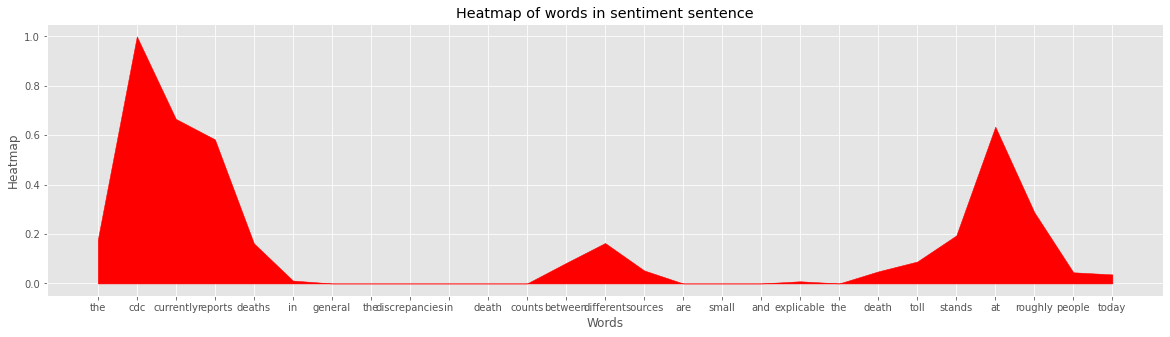

In [ ]:
words_pos = x_raw_pos[0].split()
plt.style.use('ggplot')
x_pos = [i for i, _ in enumerate(words_pos)]
plt.figure(figsize=(20,5))
plt.fill_between(x_pos, ret['heatmap'][0][:len(words_pos)],  color='r')
plt.xlabel("Words")
plt.ylabel("Heatmap")
plt.title("Heatmap of words in sentiment sentence")
plt.xticks(x_pos, words_pos)
plt.savefig('darkon-positive2.png')
plt.show()

**Get gradcam result of negative sentiment sentences**

In [ ]:
x_test_neg = x_test_batch_neg[0]
#insp = darkon.Gradcam(input_x, 2, conv_name, prob_name, graph=graph)
insp = Gradcam(input_x, 2, conv_name, prob_name, graph=graph)
ret = insp.gradcam(sess, x_test_neg,feed_options={dropout_keep_prob: 1})
idx = np.argsort(ret['heatmap'][0])[::-1]

2022-07-24 14:15:14,772 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,791 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,795 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,799 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,807 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,816 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,821 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,826 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,835 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,837 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,840 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,844 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,850 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,852 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,856 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,859 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,861 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,864 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,866 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,869 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,872 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,874 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,877 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,880 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,883 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,886 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,890 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,893 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,896 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,898 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,900 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,903 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,906 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,908 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,911 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,913 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,916 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,919 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,921 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,924 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,926 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,929 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,932 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,941 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,944 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,951 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,954 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,956 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,963 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,966 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,971 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,974 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,979 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,984 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,988 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:14,991 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:14,995 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,008 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,014 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,017 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,052 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,065 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,084 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,095 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,110 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,125 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,140 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,155 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,168 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,184 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,203 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,218 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,225 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,241 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,254 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,261 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,275 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,289 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,305 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,311 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,326 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,340 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,348 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,355 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,365 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,376 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,388 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,392 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,408 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,414 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,426 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,438 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,446 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,455 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,464 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,473 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,479 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,489 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,497 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,507 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,511 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,524 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,538 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,552 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,565 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,576 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,589 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,598 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,609 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,619 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,632 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,640 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,655 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,666 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,676 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,687 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,693 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,696 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,709 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,711 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,720 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,722 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,752 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,766 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,774 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,788 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,799 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,810 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,823 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,838 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,844 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,855 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,868 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,881 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,894 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,904 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,919 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,934 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,949 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,959 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:15,975 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:15,986 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,004 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,010 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,020 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,032 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,045 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,059 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,066 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,077 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,096 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,109 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,131 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,143 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,157 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,172 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,181 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,192 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,210 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,224 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,237 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,260 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,263 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,278 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,296 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,311 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,330 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,343 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,362 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,379 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,393 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,403 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,412 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,414 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,497 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,510 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,513 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,524 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,534 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,546 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,558 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,572 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,577 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,587 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,593 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,604 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,616 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,629 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,641 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,650 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,661 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,676 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,684 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,694 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,705 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,715 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,728 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,739 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,748 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,759 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,771 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,781 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,794 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,808 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,814 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,830 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,836 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,848 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,859 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,872 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,883 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,889 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,903 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,915 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,926 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,932 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,941 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,952 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,961 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,972 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,980 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:16,992 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:16,999 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,009 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,019 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,025 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,039 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,056 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,069 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,078 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,087 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,107 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,120 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,132 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,145 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,155 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,167 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,176 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,190 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,197 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,213 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,235 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,248 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,254 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,258 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,263 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,267 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,278 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,328 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,350 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,385 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,405 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,418 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,439 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,446 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,455 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,462 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,474 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,487 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,507 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,511 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,528 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,542 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,561 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,579 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,591 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,602 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,612 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,629 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,642 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,680 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,685 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,698 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,702 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,716 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,726 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,734 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,744 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,754 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,761 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,771 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,782 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,795 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,805 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,814 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,831 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,838 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,853 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,864 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,878 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,895 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,903 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,909 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,918 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,923 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,933 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,941 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,947 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,954 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,964 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,974 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,977 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:17,988 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:17,991 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,001 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,004 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,023 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,029 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,045 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,051 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,057 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,085 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,092 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,097 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,105 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,110 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,130 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,138 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,145 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,147 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,151 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,155 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,161 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,167 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,170 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,175 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,187 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,194 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,199 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,205 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,217 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,222 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,231 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,234 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,238 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,254 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,259 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,266 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,272 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,278 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,285 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,288 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,294 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,304 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,310 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,315 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,319 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,324 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,338 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,346 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,352 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,357 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,366 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,382 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,386 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,393 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,399 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,407 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,428 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,435 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,440 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,450 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,460 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,463 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,474 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,477 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,489 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,501 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,504 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,512 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,516 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,520 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,535 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,539 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,547 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,558 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,568 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,576 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,584 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,593 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,603 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,615 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,621 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,628 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,637 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,653 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,660 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,681 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,706 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,710 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,714 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,721 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,730 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,742 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,747 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,797 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,830 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,858 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,881 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:18,897 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:18,955 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,021 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,043 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,059 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,079 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,082 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,086 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,112 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,115 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,125 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,133 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,140 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,144 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,154 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,159 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,174 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,187 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,198 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,204 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,229 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,272 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,298 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,325 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,337 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,353 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,388 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,400 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,409 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,422 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,437 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,451 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,457 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,471 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,480 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,497 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,507 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,521 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,529 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,550 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,566 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,585 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,593 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,615 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,625 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,634 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,643 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,661 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,664 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,670 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,699 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,708 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,712 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,726 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,735 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,766 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,777 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,789 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,797 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,802 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,819 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,874 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,886 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,905 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,913 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,927 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,934 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,960 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,978 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:19,985 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:19,995 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,018 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,023 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,042 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,050 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,053 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,068 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,078 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,089 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,094 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,118 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,122 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,135 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,146 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,156 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,165 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,199 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,212 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,220 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,223 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,235 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,242 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,257 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,270 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,282 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,299 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,314 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,326 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,335 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,341 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,346 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,353 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,364 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,372 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,384 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,389 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,397 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,400 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,403 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,411 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,417 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,422 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,426 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,432 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,435 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,439 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,443 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,448 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,452 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,457 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,462 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,466 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,471 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,474 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,478 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,481 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,484 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,487 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,493 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,497 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,501 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,505 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,509 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,515 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,519 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,524 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,528 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,533 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,537 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,542 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,548 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,552 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,560 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,566 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,571 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,575 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,579 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,582 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,587 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,592 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,597 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,601 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,604 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,607 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,610 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,613 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,620 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,625 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,629 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,633 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,637 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,641 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,645 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,650 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,654 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,659 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,663 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,667 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,672 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,677 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,680 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,685 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,688 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,692 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,697 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,701 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,706 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,710 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,714 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,718 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,722 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,729 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,732 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,736 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,740 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,746 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,749 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,754 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,759 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,763 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,769 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,772 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,778 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,781 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,785 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,788 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,792 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,795 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,799 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,802 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,806 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,809 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,813 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,816 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,819 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,823 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,826 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,829 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,833 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,841 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,845 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,850 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,855 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,859 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,862 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,865 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,867 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,870 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,873 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,875 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,878 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,881 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,884 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,886 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,889 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,892 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,895 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,897 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,901 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,903 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,906 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,909 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,912 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,914 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,917 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,920 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,922 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,925 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,928 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,931 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,934 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,937 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,939 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,942 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,945 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,948 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,950 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,953 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,956 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,959 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,962 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,964 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,967 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,970 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,972 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,975 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,978 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,980 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,983 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,986 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,988 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,991 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:20,994 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:20,997 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,000 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,003 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,005 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,008 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,014 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,016 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,019 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,023 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,025 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,028 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,033 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,035 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,038 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,043 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,045 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,051 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,053 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,055 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,061 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,063 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,066 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,071 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,073 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,076 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,079 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,082 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,084 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,087 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,090 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,092 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,095 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,097 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,100 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,103 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,105 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,108 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,110 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,113 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,116 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,118 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,121 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,124 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,126 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,129 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,132 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,134 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,137 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,140 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,142 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,145 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,147 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,150 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,152 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,155 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,158 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,161 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,166 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,170 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,173 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,175 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,179 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,191 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,194 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,197 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,200 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,203 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,206 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,211 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,213 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,216 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,219 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,222 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,225 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,232 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,234 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,237 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,240 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,242 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,245 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,248 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,250 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,253 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,255 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,258 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,261 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,263 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,266 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,269 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,271 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,274 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,277 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,279 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,282 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,285 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,288 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,290 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,293 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,296 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,298 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,301 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,304 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,306 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,309 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,311 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,314 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,317 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,319 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,322 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,325 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,327 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,330 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,332 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,335 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,337 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,340 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,342 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,345 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,347 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,350 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,352 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,354 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,356 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,359 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,361 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,364 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,366 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,369 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,371 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,373 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,377 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,379 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,382 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,384 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,387 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,389 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,392 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,394 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,397 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,399 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,402 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,404 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,409 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,411 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,414 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,416 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,419 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,422 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,424 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,427 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,429 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,432 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,434 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,437 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,440 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,443 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,449 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,451 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,454 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,457 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,460 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,463 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,465 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,468 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,470 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,473 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,475 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,478 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,480 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,483 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,486 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,488 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,491 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,494 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,496 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,499 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,501 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,504 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,507 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,509 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,512 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,515 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,517 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,520 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,522 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,525 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,527 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,530 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,533 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,535 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,538 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,540 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,543 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,545 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,548 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,550 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,553 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,556 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,560 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,563 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,565 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,568 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,571 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,574 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,576 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,579 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,581 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,584 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,586 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,589 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,592 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,594 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,597 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,599 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,602 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,604 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,607 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,609 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,612 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,614 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,617 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,619 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,622 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,625 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,627 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,630 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,632 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,635 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,638 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,640 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,643 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,646 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,649 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,651 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,654 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,656 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,659 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,661 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,664 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,667 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,669 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,672 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,674 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,676 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,679 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,681 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,683 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,686 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,688 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,691 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,693 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,695 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,698 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,700 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,703 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,706 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,708 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,711 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,713 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,715 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,718 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,721 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,723 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,725 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,728 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,731 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,733 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,736 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,739 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,741 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,743 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,746 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,748 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,751 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,753 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,756 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,758 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,761 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,763 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,766 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,768 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,771 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,773 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,776 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,778 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,781 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,783 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,787 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,790 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,792 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,794 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,797 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,799 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,802 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,804 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,807 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,809 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,812 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,814 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,817 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,819 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,822 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,824 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,827 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,829 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,832 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,835 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,837 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,840 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,843 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,845 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,848 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,850 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,853 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,855 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,858 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,861 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,863 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,866 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,868 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,871 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,873 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,876 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,879 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,881 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,884 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,886 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,888 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,891 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,894 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,896 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,899 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,901 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,904 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,906 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,909 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,911 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,914 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,916 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,919 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,922 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,924 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,926 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,929 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,932 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,935 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,937 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,940 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,943 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,945 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,948 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,950 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,953 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,955 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,958 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,961 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,963 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,966 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,968 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,971 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,974 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,976 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,979 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,981 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,984 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,987 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,989 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,992 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,994 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:21,997 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:21,999 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,002 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,004 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,007 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,010 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,012 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,014 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,017 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,019 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,021 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,024 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,026 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,029 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,032 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,034 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,037 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,039 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,042 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,044 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,047 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,049 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,052 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,054 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,057 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,060 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,062 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,065 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,068 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,073 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,076 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,078 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,081 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,084 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,086 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,089 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,091 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,094 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,097 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,099 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,102 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,104 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,107 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,110 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,113 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,116 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,118 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,121 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,124 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,126 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,129 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,131 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,134 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,136 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,139 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,141 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,143 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,145 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,148 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,150 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,153 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,155 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,158 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,160 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,162 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,165 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,168 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,170 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,172 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,175 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,178 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,180 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,183 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,186 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,189 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,191 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,194 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,196 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,199 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,201 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,204 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,207 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,209 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,212 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,215 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,217 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,220 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,222 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,225 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,228 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,230 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,233 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,235 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,238 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,241 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,243 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,246 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,249 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,251 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,254 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,257 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,259 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,262 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,264 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,267 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,269 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,272 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,275 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,277 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,280 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,282 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,285 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,287 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,290 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,292 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,295 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,297 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,300 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,303 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,305 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,308 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,310 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,313 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,316 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,318 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,321 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,324 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,326 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,328 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,331 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,333 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,335 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,338 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,340 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,343 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,345 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,348 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,350 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,353 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,355 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,359 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,361 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,364 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,366 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,369 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,371 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,374 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,377 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,379 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,382 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,384 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,387 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,390 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,392 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,394 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,397 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,399 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,402 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,405 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,408 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,410 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,413 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,415 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,418 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,420 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,423 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,425 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,428 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,430 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,433 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,436 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,438 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,441 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,443 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,446 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,448 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,451 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,453 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,456 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,460 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,462 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,465 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,467 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,470 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,472 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,475 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,477 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,480 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,483 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,486 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,488 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,490 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,493 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,495 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,498 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,500 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,503 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,506 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,508 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,511 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,513 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,516 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,519 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,521 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,524 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,527 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,529 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,532 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,535 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,537 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,540 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,543 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,546 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,549 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,551 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,554 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,558 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,561 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,563 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,565 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,568 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,570 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,573 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,576 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,578 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,581 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,583 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,586 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,588 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,591 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,593 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,596 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,598 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,600 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,603 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,605 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,608 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,610 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,612 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,615 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,617 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,620 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,622 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,625 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,627 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,630 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,632 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,635 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,637 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,640 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,642 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,645 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,647 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,649 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,652 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,654 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,657 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,659 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,662 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,664 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,667 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,669 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,672 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,674 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,677 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,679 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,681 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,684 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,686 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,689 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,691 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,693 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,696 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,698 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,701 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,703 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,705 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,708 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,710 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,713 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,715 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,717 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,720 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,722 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,725 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,728 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,730 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,733 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,735 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,737 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,739 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,742 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,744 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,746 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,749 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,751 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,754 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,756 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,759 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,761 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,764 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,766 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,769 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,771 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,773 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,776 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,778 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,780 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,783 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,785 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,788 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,790 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,792 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,795 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,797 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,800 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,802 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,804 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,807 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,809 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,811 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,814 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,816 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,819 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,822 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,824 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,826 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,829 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,831 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,833 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,836 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,838 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,841 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,843 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,845 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,848 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,850 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,852 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,855 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,857 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,859 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,862 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,864 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,866 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,869 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,871 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,874 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,876 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,878 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,881 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,883 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,886 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,888 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,890 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,893 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,895 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,898 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,900 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,902 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,905 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,907 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,910 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,912 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,915 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,917 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,919 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,922 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,924 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,927 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,929 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,932 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,934 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,937 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,939 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,942 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,944 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,947 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,949 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,952 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,954 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,956 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,959 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,961 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,964 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,966 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,969 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,971 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,973 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,986 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,990 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:22,994 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:22,997 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,000 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,004 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,008 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,012 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,016 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,019 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,022 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,025 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,029 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,032 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,036 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,040 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,049 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,054 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,059 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,063 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,067 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,071 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,077 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,083 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,087 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,090 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,095 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,101 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,106 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,111 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,116 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,120 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,123 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,129 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,134 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,138 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,142 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,149 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,152 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,157 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,161 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,166 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,169 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,174 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,178 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,183 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,187 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,191 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,195 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,200 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,203 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,207 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,210 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,213 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,215 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,219 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,222 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,225 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,228 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,231 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,238 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,244 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,248 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,251 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,255 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,259 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,263 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,268 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,271 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,277 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,281 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,284 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,289 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,293 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,296 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,300 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,304 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,308 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,313 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,317 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,321 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,324 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,329 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,337 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,339 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,345 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,348 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,350 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,356 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,359 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,361 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,368 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,371 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,373 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,380 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,383 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,385 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,392 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,395 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,398 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,400 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,402 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,405 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,407 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,410 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,412 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,415 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,417 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,420 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,422 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,425 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,427 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,430 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,432 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,435 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,437 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,440 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,443 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,445 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,448 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,451 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,453 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,456 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,458 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,461 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,463 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,466 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,468 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,471 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,473 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,476 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,478 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,481 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,483 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,486 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,488 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,490 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,493 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,495 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,498 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,500 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,503 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,505 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,508 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,510 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,513 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,515 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,517 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,520 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,523 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,526 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,528 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,531 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,533 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,536 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,538 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,541 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,544 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,547 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,550 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,552 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,555 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,559 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,562 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,564 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,567 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,570 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,572 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,575 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,577 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,580 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,586 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,588 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,591 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,593 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,596 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,598 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,601 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,603 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,606 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,608 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,611 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,613 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,616 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,618 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,621 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,623 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,626 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,628 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,631 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,633 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,636 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,639 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,641 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,644 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,646 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,649 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,651 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,654 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,656 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,659 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,661 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,664 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,667 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,669 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,671 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,674 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,676 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,678 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,681 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,683 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,686 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,688 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,690 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,693 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,695 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,698 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,700 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,703 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,706 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,708 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,710 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,713 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,715 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,718 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,720 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,723 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,725 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,728 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,730 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,733 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,735 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,737 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,740 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,742 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,745 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,747 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,750 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,752 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,755 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,757 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,760 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,762 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,764 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,767 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,769 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,772 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,774 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,777 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,779 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,782 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,784 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,787 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,790 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,792 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,795 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,797 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,800 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,802 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,805 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,807 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,810 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,812 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,815 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,817 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,820 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,822 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,825 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,827 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,830 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,833 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,835 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,838 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,841 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,843 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,846 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,848 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,851 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,853 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,856 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,858 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,861 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,864 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,866 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,869 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,872 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,874 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,877 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,880 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,883 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,886 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,889 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,893 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,896 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,899 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,908 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,911 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,915 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,918 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,923 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,927 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,932 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,937 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,941 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,945 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,949 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,951 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,954 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,957 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,960 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,964 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,967 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,971 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,974 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,977 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,980 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,983 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,987 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,990 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:23,993 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:23,997 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,001 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,009 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,013 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,016 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,019 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,023 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,026 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,032 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,035 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,039 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,043 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,046 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,050 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,054 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,059 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,062 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,067 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,070 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,075 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,078 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,083 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,087 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,091 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,094 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,099 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,102 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,105 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,110 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,112 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,117 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,120 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,124 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,128 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,134 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,137 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,142 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,146 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,150 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,153 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,158 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,161 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,165 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,169 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,173 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,181 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,185 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,189 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,193 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,197 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,201 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,203 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,207 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,211 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,214 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,218 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,222 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,226 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,231 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,234 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,238 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,240 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,243 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,247 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,250 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,257 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,260 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,264 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,267 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,272 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,275 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,279 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,284 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,288 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,292 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,297 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,301 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,305 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,311 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,315 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,320 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,325 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,329 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,332 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,337 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,341 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,344 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,348 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,352 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,356 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,361 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,365 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,370 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,375 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,380 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,383 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,388 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,392 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,397 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,400 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,406 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,409 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,413 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,417 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,422 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,426 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,430 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,435 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,438 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,442 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,447 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,450 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,455 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,458 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,462 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,467 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,472 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,477 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,481 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,485 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,490 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,493 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,496 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,500 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,502 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,505 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,509 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,512 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,515 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,518 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,521 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,524 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,528 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,531 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,534 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,537 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,540 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,544 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,552 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,559 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,562 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,566 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,570 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,574 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,578 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,582 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,587 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,592 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,597 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,601 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,606 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,610 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,614 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,617 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,622 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,625 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,628 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,633 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,639 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,642 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,648 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,651 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,656 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,659 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,663 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,668 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,673 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,678 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,680 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,685 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,689 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,694 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,699 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,701 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,706 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,716 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,720 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,724 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,729 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,733 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,738 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,741 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,746 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,749 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,752 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,756 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,760 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,764 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,767 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,772 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,776 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,780 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,784 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,787 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,790 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,792 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,797 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,801 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,806 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,808 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,813 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,818 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,822 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,826 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,831 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,836 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,840 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,843 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,847 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,852 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,856 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,860 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,864 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,868 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,880 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,885 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,889 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,893 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,897 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,900 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,904 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,908 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,911 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,915 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,919 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,924 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,928 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,933 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,936 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,940 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,944 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,948 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,953 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,956 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,962 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,966 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,969 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,974 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,977 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,981 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,984 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,987 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,991 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:24,995 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:24,999 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,004 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,007 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,012 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,015 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,020 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,023 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,029 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,032 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,035 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,041 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,044 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,049 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,053 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,056 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,061 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,064 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,069 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,072 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,075 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,081 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,085 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,088 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,090 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,096 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,101 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,103 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,108 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,112 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,117 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,121 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,126 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,131 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,135 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,137 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,140 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,143 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,146 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,148 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,151 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,154 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,156 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,159 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,161 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,164 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,167 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,169 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,173 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,176 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,179 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,181 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,184 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,187 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,189 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,192 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,195 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,198 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,200 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,203 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,206 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,209 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,211 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,214 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,217 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,219 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,222 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,224 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,227 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,229 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,231 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,234 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,236 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,238 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,241 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,244 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,246 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,249 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,251 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,254 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,257 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,259 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,262 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,264 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,267 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,269 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,272 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,274 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,277 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,279 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,282 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,284 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,286 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,289 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,292 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,294 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,297 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,299 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,301 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,304 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,306 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,309 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,311 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,314 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,316 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,319 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,321 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,324 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,327 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,329 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,332 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,335 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,337 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,340 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,343 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,345 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,348 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,353 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,355 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,358 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,361 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,365 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,367 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,370 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,374 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,377 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,383 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,387 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,389 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,396 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,398 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,401 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,407 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,409 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,417 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,419 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,422 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,428 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,430 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,433 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,435 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,437 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,440 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,443 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,445 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,448 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,450 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,453 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,456 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,458 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,461 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,464 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,466 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,469 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,472 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,474 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,477 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,479 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,482 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,484 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,487 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,489 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,492 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,494 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,497 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,500 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,502 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,505 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,507 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,509 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,512 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,515 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,517 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,520 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,522 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,525 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,527 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,530 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,533 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,535 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,538 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,541 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,544 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,546 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,549 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,551 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,554 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,557 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,560 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,563 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,565 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,568 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,571 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,574 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,577 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,579 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,582 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,584 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,587 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,590 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,592 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,594 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,597 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,599 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,602 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,604 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,607 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,609 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,612 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,614 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,617 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,619 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,622 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,636 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,641 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,645 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,649 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,652 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,656 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,661 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,665 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,670 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,674 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,677 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,681 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,684 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,688 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,693 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,696 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,700 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,703 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,707 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,712 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,715 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,718 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,723 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,726 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,730 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,735 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,737 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,742 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,746 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,750 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,754 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,757 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,759 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,765 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,767 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,770 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,776 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,779 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,785 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,787 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,793 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,795 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,802 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,804 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,811 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,813 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,820 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,822 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,825 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,827 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,830 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,833 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,835 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,838 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,840 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,843 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,846 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,849 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,853 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,856 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,858 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,861 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,863 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,866 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,868 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,871 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,873 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,875 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,878 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,880 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,883 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,885 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,888 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,890 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,893 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,895 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,898 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,900 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,903 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,905 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,907 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,910 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,912 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,915 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,917 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,920 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,922 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,924 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,927 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,929 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,931 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,934 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,936 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,939 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,941 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,943 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,946 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,948 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,951 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,953 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,956 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,958 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,960 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,963 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,965 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,968 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,970 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,973 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,975 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,978 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,980 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,982 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,985 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,987 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,990 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,992 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:25,995 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:25,997 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,000 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,002 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,005 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,007 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,010 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,014 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,017 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,020 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,022 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,025 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,030 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,032 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,035 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,038 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,040 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,043 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,046 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,048 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,051 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,053 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,056 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,058 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,061 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,064 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,066 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,069 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,071 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,074 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,076 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,079 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,081 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,084 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,086 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,089 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,091 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,094 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,097 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,099 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,102 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,104 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,107 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,109 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,112 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,115 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,117 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,120 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,122 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,125 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,128 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,130 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,133 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,135 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,138 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,140 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,143 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,146 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,148 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,151 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,153 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,156 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,158 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,161 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,163 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,166 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,168 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,171 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,175 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,178 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,180 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,183 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,185 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,188 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,191 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,193 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,196 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,199 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,201 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,203 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,206 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,209 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,211 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,225 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,228 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,230 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,233 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,235 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,238 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,241 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,243 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,246 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,249 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,252 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,254 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,258 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,260 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,263 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,267 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,269 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,272 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,275 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,278 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,280 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,283 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,286 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,290 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,293 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,296 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,299 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,302 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,307 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,310 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,312 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,316 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,322 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,325 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,327 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,330 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,334 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,338 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,341 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,347 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,350 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,352 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,358 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,361 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,368 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,371 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,373 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,377 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,380 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,382 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,385 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,388 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,391 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,394 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,396 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,399 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,402 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,405 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,408 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,411 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,413 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,416 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,419 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,421 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,424 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,426 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,429 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,432 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,435 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,437 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,440 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,443 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,446 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,448 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,451 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,454 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,456 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,459 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,462 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,464 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,467 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,470 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,473 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,475 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,478 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,481 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,483 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,486 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,489 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,491 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,494 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,496 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,499 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,501 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,504 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,507 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,509 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,512 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,514 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,517 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,520 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,522 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,525 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,527 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,530 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,532 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,535 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,537 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,540 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,542 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,545 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,547 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,549 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,552 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,554 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,558 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,561 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,563 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,566 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,568 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,572 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,586 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,588 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,591 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,594 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,597 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,606 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,611 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,615 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,620 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,624 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,627 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,632 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,636 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,642 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,645 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,648 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,652 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,658 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,661 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,663 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,666 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,668 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,671 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,673 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,676 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,678 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,681 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,683 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,686 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,688 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,691 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,693 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,696 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,698 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,701 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,703 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,707 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,709 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,711 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,714 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,717 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,719 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,722 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,724 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,727 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,729 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,732 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,734 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,737 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,743 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,746 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,749 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,752 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,754 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,757 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,759 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,761 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,764 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,766 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,769 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,771 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,773 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,776 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,778 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,780 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,783 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,785 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,787 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,790 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,792 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,795 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,797 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,800 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,802 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,804 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,807 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,809 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,812 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,814 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,816 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,819 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,821 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,824 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,827 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,829 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,832 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,834 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,837 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,839 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,842 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,844 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,847 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,849 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,852 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,854 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,856 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,859 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,861 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,864 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,866 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,869 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,871 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,874 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,876 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,879 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,881 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,884 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,886 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,889 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,891 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,894 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,896 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,898 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,901 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,903 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,906 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,909 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,911 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,913 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,916 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,918 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,921 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,923 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,925 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,928 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,931 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,933 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,935 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,938 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,940 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,943 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,945 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,947 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,950 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,952 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,955 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,957 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,960 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,962 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,964 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,967 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,969 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,972 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,974 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,977 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,979 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,982 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,984 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,986 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,989 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,991 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,994 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:26,996 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:26,999 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,001 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,004 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,007 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,009 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,011 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,014 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,017 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,019 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,021 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,024 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,026 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,029 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,031 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,033 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,036 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,038 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,040 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,043 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,045 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,047 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,050 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,052 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,055 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,057 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,059 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,062 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,065 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,067 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,069 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,072 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,075 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,077 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,079 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,082 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,093 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,098 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,102 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,107 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,111 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,115 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,119 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,124 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,127 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,133 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,137 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,142 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,150 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,154 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,158 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,162 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,167 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,171 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,177 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,181 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,184 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,191 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,199 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,203 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,208 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,212 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,217 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,221 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,224 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,228 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,232 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,237 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,241 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,246 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,253 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,255 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,260 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,263 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,269 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,272 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,275 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,281 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,283 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,289 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,291 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,295 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,298 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,303 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,307 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,315 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,318 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,321 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,327 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,330 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,337 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,340 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,346 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,348 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,350 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,353 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,356 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,358 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,361 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,364 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,366 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,369 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,372 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,375 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,377 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,380 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,383 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,386 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,388 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,391 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,394 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,397 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,399 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,402 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,404 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,407 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,410 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,412 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,415 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,417 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,420 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,422 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,425 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,427 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,430 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,432 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,435 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,437 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,440 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,442 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,445 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,448 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,450 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,453 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,455 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,458 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,460 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,463 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,465 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,467 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,470 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,472 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,475 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,477 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,480 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,482 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,484 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,487 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,489 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,491 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,494 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,497 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,499 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,502 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,505 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,507 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,509 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,512 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,514 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,516 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,519 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,521 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,524 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,526 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,528 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,531 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,533 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,536 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,538 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,541 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,543 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,546 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,548 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,551 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,553 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,556 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,562 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,565 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,568 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,575 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,578 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,580 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,587 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,590 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,592 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,599 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,601 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,604 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,607 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,613 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,616 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,618 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,621 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,627 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,630 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,632 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,640 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,643 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,646 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,650 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,654 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,659 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,663 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,669 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,673 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,678 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,683 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,687 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,692 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,697 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,701 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,706 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,712 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,717 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,722 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,726 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,729 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,733 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,739 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,745 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,749 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,757 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,761 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,765 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,769 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,774 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,779 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,785 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,788 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,791 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,795 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,799 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,805 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,809 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,811 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,815 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,820 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,824 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,829 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,836 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,841 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,843 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,846 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,849 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,852 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,856 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,859 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,863 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,868 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,872 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,876 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,880 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,885 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,889 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,893 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,899 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,903 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,907 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,911 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,915 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,921 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,925 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,929 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,933 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,937 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,941 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,945 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,949 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,955 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,959 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,964 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,968 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,972 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,978 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,981 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:27,988 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:27,994 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,000 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,005 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,009 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,014 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,017 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,022 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,026 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,031 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,034 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,038 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,042 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,045 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,048 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,051 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,054 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,057 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,059 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,062 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,066 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,069 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,072 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,075 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,078 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,082 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,085 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,091 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,095 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,101 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,104 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,107 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,110 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,117 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,120 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,125 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,129 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,133 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,139 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,144 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,147 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,154 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,160 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,164 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,168 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,171 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,174 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,179 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,186 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,191 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,195 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,200 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,205 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,209 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,213 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,217 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,221 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,226 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,230 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,234 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,237 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,241 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,244 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,248 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,251 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,254 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,257 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,261 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,264 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,267 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,270 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,273 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,277 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,283 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,287 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,290 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,293 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,297 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,301 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,304 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,307 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,310 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,313 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,321 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,325 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,329 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,332 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,337 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,340 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,344 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,349 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,352 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,357 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,360 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,364 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,368 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,372 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,376 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,381 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,385 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,389 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,394 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,398 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,402 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,407 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,411 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,415 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,420 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,424 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,428 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,431 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,433 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,439 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,442 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,448 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,451 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,453 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,459 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,462 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,467 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,471 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,476 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,483 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,485 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,488 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,494 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,497 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,499 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,503 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,506 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,511 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,515 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,519 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,523 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,527 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,533 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,536 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,540 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,551 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,559 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,563 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,567 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,570 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,575 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,579 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,585 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,589 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,593 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,597 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,602 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,606 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,609 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,614 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,619 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,623 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,628 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,632 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,636 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,641 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,645 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,650 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,654 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


2022-07-24 14:15:28,658 tensorflow WARNING: Operation._op_def is private, use Operation.op_def instead. Operation._op_def will eventually be removed.


2022-07-24 14:15:28,663 tensorflow WARNING: Operation._node_def is private, use Operation.node_def instead. Operation._node_def will eventually be removed.


**plot heatmap of the words in sentences**

politically correct woman almost uses pandemic as excuse not to reuse plastic bag coronavirus nashville


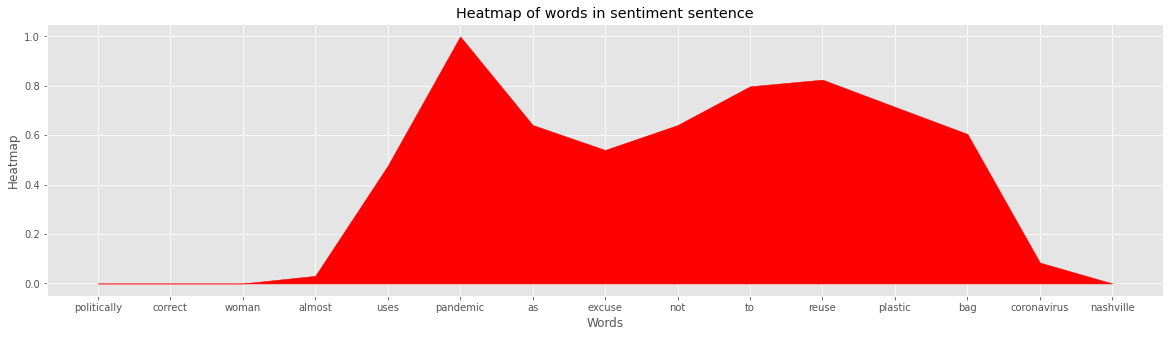

In [ ]:
words_neg = x_raw_neg[0].split()
print(x_raw_neg[0])
plt.style.use('ggplot')
x_pos = [i for i, _ in enumerate(words_neg)]
plt.figure(figsize=(20,5))
plt.fill_between(x_pos, ret['heatmap'][0][:len(words_neg)],  color='r')
plt.xlabel("Words")
plt.ylabel("Heatmap")
plt.title("Heatmap of words in sentiment sentence")
plt.xticks(x_pos, words_neg)
plt.savefig('darkon-negative1.png')
plt.show()

politically correct woman almost uses pandemic as excuse not to reuse plastic bag coronavirus nashville


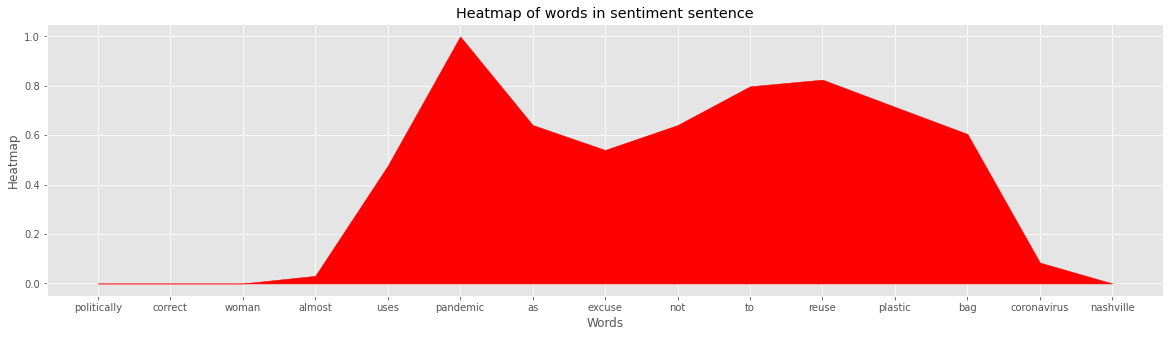

<Figure size 432x288 with 0 Axes>

In [ ]:
words_neg = x_raw_neg[0].split()
print(x_raw_neg[0])
plt.style.use('ggplot')
x_pos = [i for i, _ in enumerate(words_neg)]
plt.figure(figsize=(20,5))
plt.fill_between(x_pos, ret['heatmap'][0][:len(words_neg)],  color='r')
plt.xlabel("Words")
plt.ylabel("Heatmap")
plt.title("Heatmap of words in sentiment sentence")
plt.xticks(x_pos, words_neg)
plt.show()
plt.savefig('darkon-negative2.png')